# VAE for SMBA

This VAE is adapted from the GM-VAE implementation.

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
num_epochs=10000

## Import Libraries

In [5]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../pytorch')
from model.VAE_kld_loss import *

sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

## Load data

In [6]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [7]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [8]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [9]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [10]:
chunks = smb_onehot

## Input Parameters

In [11]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [12]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [13]:
from torch.utils.data import TensorDataset, DataLoader

In [14]:
assert args.train_proportion != 1

In [15]:
def partition_dataset(n, proportion=1):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [16]:
# Model Initialization
vae = VAE(args)

In [17]:
history_loss = vae.train(train_dl, valid_dl)

Epoch     1 / 10000 | Total loss:  464.87 | Recon loss:  458.86 | Gauss loss:     3.0
Epoch     2 / 10000 | Total loss:  223.89 | Recon loss:  222.52 | Gauss loss:    0.69
Epoch     3 / 10000 | Total loss:  218.54 | Recon loss:  217.45 | Gauss loss:    0.54
Epoch     4 / 10000 | Total loss:  204.65 | Recon loss:   203.5 | Gauss loss:    0.57
Epoch     5 / 10000 | Total loss:  192.13 | Recon loss:  190.73 | Gauss loss:     0.7
Epoch     6 / 10000 | Total loss:  184.15 | Recon loss:  182.66 | Gauss loss:    0.74
Epoch     7 / 10000 | Total loss:  177.66 | Recon loss:  176.12 | Gauss loss:    0.77
Epoch     8 / 10000 | Total loss:  171.16 | Recon loss:  169.48 | Gauss loss:    0.84
Epoch     9 / 10000 | Total loss:  164.94 | Recon loss:  163.14 | Gauss loss:     0.9
Epoch    10 / 10000 | Total loss:  158.84 | Recon loss:  156.92 | Gauss loss:    0.96
Epoch    11 / 10000 | Total loss:  152.98 | Recon loss:  150.91 | Gauss loss:    1.04
Epoch    12 / 10000 | Total loss:  148.14 | Recon loss

Epoch    97 / 10000 | Total loss:   18.65 | Recon loss:   14.26 | Gauss loss:    2.19
Epoch    98 / 10000 | Total loss:   19.27 | Recon loss:   14.85 | Gauss loss:    2.21
Epoch    99 / 10000 | Total loss:   18.74 | Recon loss:   14.33 | Gauss loss:     2.2
Epoch   100 / 10000 | Total loss:   18.56 | Recon loss:   14.16 | Gauss loss:     2.2
Epoch   101 / 10000 | Total loss:   17.51 | Recon loss:   13.17 | Gauss loss:    2.17
Epoch   102 / 10000 | Total loss:   17.19 | Recon loss:   12.84 | Gauss loss:    2.17
Epoch   103 / 10000 | Total loss:   17.54 | Recon loss:   13.14 | Gauss loss:     2.2
Epoch   104 / 10000 | Total loss:   17.62 | Recon loss:   13.25 | Gauss loss:    2.19
Epoch   105 / 10000 | Total loss:   16.98 | Recon loss:   12.66 | Gauss loss:    2.16
Epoch   106 / 10000 | Total loss:   16.85 | Recon loss:   12.57 | Gauss loss:    2.14
Epoch   107 / 10000 | Total loss:   18.69 | Recon loss:    14.4 | Gauss loss:    2.14
Epoch   108 / 10000 | Total loss:   18.97 | Recon loss

Epoch   193 / 10000 | Total loss:    5.86 | Recon loss:    2.81 | Gauss loss:    1.53
Epoch   194 / 10000 | Total loss:     5.1 | Recon loss:    2.13 | Gauss loss:    1.48
Epoch   195 / 10000 | Total loss:     4.7 | Recon loss:    1.81 | Gauss loss:    1.45
Epoch   196 / 10000 | Total loss:    4.54 | Recon loss:     1.7 | Gauss loss:    1.42
Epoch   197 / 10000 | Total loss:    4.47 | Recon loss:    1.64 | Gauss loss:    1.41
Epoch   198 / 10000 | Total loss:    4.31 | Recon loss:    1.46 | Gauss loss:    1.43
Epoch   199 / 10000 | Total loss:    4.18 | Recon loss:    1.38 | Gauss loss:     1.4
Epoch   200 / 10000 | Total loss:    4.16 | Recon loss:    1.37 | Gauss loss:    1.39
Epoch   201 / 10000 | Total loss:     4.1 | Recon loss:    1.34 | Gauss loss:    1.38
Epoch   202 / 10000 | Total loss:    4.13 | Recon loss:    1.34 | Gauss loss:    1.39
Epoch   203 / 10000 | Total loss:    4.14 | Recon loss:    1.37 | Gauss loss:    1.39
Epoch   204 / 10000 | Total loss:    4.19 | Recon loss

Epoch   289 / 10000 | Total loss:    3.02 | Recon loss:    0.79 | Gauss loss:    1.11
Epoch   290 / 10000 | Total loss:    3.06 | Recon loss:    0.79 | Gauss loss:    1.13
Epoch   291 / 10000 | Total loss:    3.01 | Recon loss:    0.77 | Gauss loss:    1.12
Epoch   292 / 10000 | Total loss:    3.27 | Recon loss:    0.99 | Gauss loss:    1.14
Epoch   293 / 10000 | Total loss:    3.54 | Recon loss:    1.19 | Gauss loss:    1.18
Epoch   294 / 10000 | Total loss:    3.76 | Recon loss:    1.36 | Gauss loss:     1.2
Epoch   295 / 10000 | Total loss:     3.6 | Recon loss:    1.26 | Gauss loss:    1.17
Epoch   296 / 10000 | Total loss:    3.57 | Recon loss:    1.18 | Gauss loss:    1.19
Epoch   297 / 10000 | Total loss:    3.62 | Recon loss:    1.27 | Gauss loss:    1.18
Epoch   298 / 10000 | Total loss:    3.69 | Recon loss:    1.32 | Gauss loss:    1.19
Epoch   299 / 10000 | Total loss:    3.77 | Recon loss:     1.4 | Gauss loss:    1.19
Epoch   300 / 10000 | Total loss:    3.79 | Recon loss

Epoch   385 / 10000 | Total loss:    2.61 | Recon loss:    0.61 | Gauss loss:     1.0
Epoch   386 / 10000 | Total loss:     2.6 | Recon loss:    0.65 | Gauss loss:    0.98
Epoch   387 / 10000 | Total loss:    3.38 | Recon loss:    1.28 | Gauss loss:    1.05
Epoch   388 / 10000 | Total loss:    3.65 | Recon loss:    1.46 | Gauss loss:     1.1
Epoch   389 / 10000 | Total loss:    3.59 | Recon loss:    1.36 | Gauss loss:    1.11
Epoch   390 / 10000 | Total loss:    3.54 | Recon loss:    1.35 | Gauss loss:     1.1
Epoch   391 / 10000 | Total loss:    3.86 | Recon loss:    1.59 | Gauss loss:    1.14
Epoch   392 / 10000 | Total loss:    4.21 | Recon loss:    1.93 | Gauss loss:    1.14
Epoch   393 / 10000 | Total loss:     4.2 | Recon loss:     1.9 | Gauss loss:    1.15
Epoch   394 / 10000 | Total loss:    4.39 | Recon loss:    2.08 | Gauss loss:    1.16
Epoch   395 / 10000 | Total loss:     4.5 | Recon loss:    2.15 | Gauss loss:    1.18
Epoch   396 / 10000 | Total loss:    4.31 | Recon loss

Epoch   481 / 10000 | Total loss:    4.33 | Recon loss:    2.17 | Gauss loss:    1.08
Epoch   482 / 10000 | Total loss:    6.46 | Recon loss:    4.15 | Gauss loss:    1.16
Epoch   483 / 10000 | Total loss:   10.17 | Recon loss:    7.69 | Gauss loss:    1.24
Epoch   484 / 10000 | Total loss:   18.31 | Recon loss:   15.66 | Gauss loss:    1.32
Epoch   485 / 10000 | Total loss:   26.18 | Recon loss:   23.42 | Gauss loss:    1.38
Epoch   486 / 10000 | Total loss:   16.77 | Recon loss:   13.84 | Gauss loss:    1.47
Epoch   487 / 10000 | Total loss:    8.57 | Recon loss:    5.78 | Gauss loss:     1.4
Epoch   488 / 10000 | Total loss:    4.57 | Recon loss:    2.07 | Gauss loss:    1.25
Epoch   489 / 10000 | Total loss:    3.07 | Recon loss:    0.89 | Gauss loss:    1.09
Epoch   490 / 10000 | Total loss:    2.48 | Recon loss:    0.54 | Gauss loss:    0.97
Epoch   491 / 10000 | Total loss:    2.32 | Recon loss:    0.45 | Gauss loss:    0.93
Epoch   492 / 10000 | Total loss:    2.23 | Recon loss

Epoch   577 / 10000 | Total loss:    2.09 | Recon loss:    0.44 | Gauss loss:    0.82
Epoch   578 / 10000 | Total loss:    2.14 | Recon loss:    0.48 | Gauss loss:    0.83
Epoch   579 / 10000 | Total loss:    2.11 | Recon loss:    0.43 | Gauss loss:    0.84
Epoch   580 / 10000 | Total loss:    2.14 | Recon loss:    0.48 | Gauss loss:    0.83
Epoch   581 / 10000 | Total loss:    2.16 | Recon loss:    0.48 | Gauss loss:    0.84
Epoch   582 / 10000 | Total loss:     2.2 | Recon loss:     0.5 | Gauss loss:    0.85
Epoch   583 / 10000 | Total loss:    2.54 | Recon loss:    0.77 | Gauss loss:    0.88
Epoch   584 / 10000 | Total loss:    2.41 | Recon loss:    0.65 | Gauss loss:    0.88
Epoch   585 / 10000 | Total loss:    2.39 | Recon loss:    0.65 | Gauss loss:    0.87
Epoch   586 / 10000 | Total loss:     2.5 | Recon loss:    0.72 | Gauss loss:    0.89
Epoch   587 / 10000 | Total loss:    2.61 | Recon loss:    0.82 | Gauss loss:     0.9
Epoch   588 / 10000 | Total loss:     4.8 | Recon loss

Epoch   673 / 10000 | Total loss:    3.51 | Recon loss:    1.66 | Gauss loss:    0.93
Epoch   674 / 10000 | Total loss:    3.76 | Recon loss:    1.85 | Gauss loss:    0.95
Epoch   675 / 10000 | Total loss:     3.3 | Recon loss:    1.41 | Gauss loss:    0.95
Epoch   676 / 10000 | Total loss:    2.96 | Recon loss:     1.1 | Gauss loss:    0.93
Epoch   677 / 10000 | Total loss:    2.55 | Recon loss:    0.78 | Gauss loss:    0.89
Epoch   678 / 10000 | Total loss:    2.96 | Recon loss:    1.18 | Gauss loss:    0.89
Epoch   679 / 10000 | Total loss:    3.06 | Recon loss:    1.22 | Gauss loss:    0.92
Epoch   680 / 10000 | Total loss:    3.29 | Recon loss:    1.42 | Gauss loss:    0.93
Epoch   681 / 10000 | Total loss:    3.27 | Recon loss:    1.37 | Gauss loss:    0.95
Epoch   682 / 10000 | Total loss:    3.09 | Recon loss:     1.2 | Gauss loss:    0.94
Epoch   683 / 10000 | Total loss:    3.11 | Recon loss:    1.27 | Gauss loss:    0.92
Epoch   684 / 10000 | Total loss:    3.22 | Recon loss

Epoch   769 / 10000 | Total loss:    3.42 | Recon loss:    1.57 | Gauss loss:    0.92
Epoch   770 / 10000 | Total loss:    2.96 | Recon loss:    1.18 | Gauss loss:    0.89
Epoch   771 / 10000 | Total loss:    3.59 | Recon loss:    1.79 | Gauss loss:     0.9
Epoch   772 / 10000 | Total loss:    3.93 | Recon loss:    2.07 | Gauss loss:    0.93
Epoch   773 / 10000 | Total loss:    3.93 | Recon loss:    2.03 | Gauss loss:    0.95
Epoch   774 / 10000 | Total loss:    4.04 | Recon loss:    2.12 | Gauss loss:    0.96
Epoch   775 / 10000 | Total loss:    4.44 | Recon loss:     2.5 | Gauss loss:    0.97
Epoch   776 / 10000 | Total loss:     4.6 | Recon loss:    2.63 | Gauss loss:    0.99
Epoch   777 / 10000 | Total loss:    5.04 | Recon loss:    3.05 | Gauss loss:     1.0
Epoch   778 / 10000 | Total loss:    5.27 | Recon loss:    3.19 | Gauss loss:    1.04
Epoch   779 / 10000 | Total loss:    4.07 | Recon loss:    2.11 | Gauss loss:    0.98
Epoch   780 / 10000 | Total loss:    3.52 | Recon loss

Epoch   865 / 10000 | Total loss:    1.61 | Recon loss:    0.24 | Gauss loss:    0.68
Epoch   866 / 10000 | Total loss:    1.65 | Recon loss:    0.31 | Gauss loss:    0.67
Epoch   867 / 10000 | Total loss:    1.63 | Recon loss:    0.27 | Gauss loss:    0.68
Epoch   868 / 10000 | Total loss:    1.68 | Recon loss:    0.32 | Gauss loss:    0.68
Epoch   869 / 10000 | Total loss:     1.6 | Recon loss:    0.27 | Gauss loss:    0.67
Epoch   870 / 10000 | Total loss:    1.61 | Recon loss:    0.27 | Gauss loss:    0.67
Epoch   871 / 10000 | Total loss:    1.58 | Recon loss:    0.26 | Gauss loss:    0.66
Epoch   872 / 10000 | Total loss:    1.66 | Recon loss:     0.3 | Gauss loss:    0.68
Epoch   873 / 10000 | Total loss:    1.64 | Recon loss:     0.3 | Gauss loss:    0.67
Epoch   874 / 10000 | Total loss:    1.61 | Recon loss:    0.26 | Gauss loss:    0.67
Epoch   875 / 10000 | Total loss:    1.64 | Recon loss:     0.3 | Gauss loss:    0.67
Epoch   876 / 10000 | Total loss:     1.7 | Recon loss

Epoch   961 / 10000 | Total loss:    1.67 | Recon loss:    0.28 | Gauss loss:     0.7
Epoch   962 / 10000 | Total loss:    1.57 | Recon loss:    0.23 | Gauss loss:    0.67
Epoch   963 / 10000 | Total loss:    1.55 | Recon loss:    0.24 | Gauss loss:    0.66
Epoch   964 / 10000 | Total loss:    1.57 | Recon loss:    0.22 | Gauss loss:    0.67
Epoch   965 / 10000 | Total loss:    1.56 | Recon loss:    0.24 | Gauss loss:    0.66
Epoch   966 / 10000 | Total loss:    1.59 | Recon loss:    0.26 | Gauss loss:    0.66
Epoch   967 / 10000 | Total loss:    1.58 | Recon loss:    0.27 | Gauss loss:    0.66
Epoch   968 / 10000 | Total loss:    1.61 | Recon loss:    0.27 | Gauss loss:    0.67
Epoch   969 / 10000 | Total loss:    1.57 | Recon loss:    0.25 | Gauss loss:    0.66
Epoch   970 / 10000 | Total loss:    1.52 | Recon loss:    0.23 | Gauss loss:    0.64
Epoch   971 / 10000 | Total loss:    1.55 | Recon loss:    0.27 | Gauss loss:    0.64
Epoch   972 / 10000 | Total loss:    1.53 | Recon loss

Epoch  1057 / 10000 | Total loss:    1.66 | Recon loss:    0.29 | Gauss loss:    0.68
Epoch  1058 / 10000 | Total loss:    1.62 | Recon loss:    0.27 | Gauss loss:    0.67
Epoch  1059 / 10000 | Total loss:    1.65 | Recon loss:    0.32 | Gauss loss:    0.67
Epoch  1060 / 10000 | Total loss:    1.68 | Recon loss:    0.33 | Gauss loss:    0.67
Epoch  1061 / 10000 | Total loss:    1.88 | Recon loss:    0.47 | Gauss loss:    0.71
Epoch  1062 / 10000 | Total loss:    1.68 | Recon loss:    0.35 | Gauss loss:    0.67
Epoch  1063 / 10000 | Total loss:    1.62 | Recon loss:     0.3 | Gauss loss:    0.66
Epoch  1064 / 10000 | Total loss:    1.76 | Recon loss:    0.42 | Gauss loss:    0.67
Epoch  1065 / 10000 | Total loss:     1.9 | Recon loss:    0.51 | Gauss loss:    0.69
Epoch  1066 / 10000 | Total loss:    1.85 | Recon loss:    0.46 | Gauss loss:     0.7
Epoch  1067 / 10000 | Total loss:    1.84 | Recon loss:    0.44 | Gauss loss:     0.7
Epoch  1068 / 10000 | Total loss:    1.81 | Recon loss

Epoch  1153 / 10000 | Total loss:    2.16 | Recon loss:    0.73 | Gauss loss:    0.71
Epoch  1154 / 10000 | Total loss:    2.28 | Recon loss:    0.77 | Gauss loss:    0.75
Epoch  1155 / 10000 | Total loss:    2.84 | Recon loss:    1.31 | Gauss loss:    0.77
Epoch  1156 / 10000 | Total loss:    3.43 | Recon loss:     1.8 | Gauss loss:    0.81
Epoch  1157 / 10000 | Total loss:    3.54 | Recon loss:    1.85 | Gauss loss:    0.84
Epoch  1158 / 10000 | Total loss:    2.87 | Recon loss:    1.26 | Gauss loss:     0.8
Epoch  1159 / 10000 | Total loss:    2.43 | Recon loss:    0.89 | Gauss loss:    0.77
Epoch  1160 / 10000 | Total loss:    2.04 | Recon loss:    0.57 | Gauss loss:    0.74
Epoch  1161 / 10000 | Total loss:    2.16 | Recon loss:    0.69 | Gauss loss:    0.74
Epoch  1162 / 10000 | Total loss:    2.14 | Recon loss:     0.7 | Gauss loss:    0.72
Epoch  1163 / 10000 | Total loss:    1.77 | Recon loss:     0.4 | Gauss loss:    0.68
Epoch  1164 / 10000 | Total loss:     1.6 | Recon loss

Epoch  1249 / 10000 | Total loss:    1.64 | Recon loss:    0.39 | Gauss loss:    0.63
Epoch  1250 / 10000 | Total loss:    1.75 | Recon loss:    0.46 | Gauss loss:    0.65
Epoch  1251 / 10000 | Total loss:    1.67 | Recon loss:    0.38 | Gauss loss:    0.64
Epoch  1252 / 10000 | Total loss:     1.8 | Recon loss:    0.48 | Gauss loss:    0.66
Epoch  1253 / 10000 | Total loss:    1.76 | Recon loss:    0.44 | Gauss loss:    0.66
Epoch  1254 / 10000 | Total loss:    1.99 | Recon loss:    0.66 | Gauss loss:    0.66
Epoch  1255 / 10000 | Total loss:    2.01 | Recon loss:    0.62 | Gauss loss:     0.7
Epoch  1256 / 10000 | Total loss:    1.89 | Recon loss:    0.53 | Gauss loss:    0.68
Epoch  1257 / 10000 | Total loss:    1.92 | Recon loss:    0.58 | Gauss loss:    0.67
Epoch  1258 / 10000 | Total loss:    2.72 | Recon loss:    1.35 | Gauss loss:    0.69
Epoch  1259 / 10000 | Total loss:   11.79 | Recon loss:   10.05 | Gauss loss:    0.87
Epoch  1260 / 10000 | Total loss:   14.23 | Recon loss

Epoch  1345 / 10000 | Total loss:    1.62 | Recon loss:    0.32 | Gauss loss:    0.65
Epoch  1346 / 10000 | Total loss:     1.5 | Recon loss:    0.25 | Gauss loss:    0.62
Epoch  1347 / 10000 | Total loss:    1.49 | Recon loss:    0.26 | Gauss loss:    0.61
Epoch  1348 / 10000 | Total loss:    2.21 | Recon loss:    0.89 | Gauss loss:    0.66
Epoch  1349 / 10000 | Total loss:    3.07 | Recon loss:    1.56 | Gauss loss:    0.75
Epoch  1350 / 10000 | Total loss:    3.96 | Recon loss:    2.36 | Gauss loss:     0.8
Epoch  1351 / 10000 | Total loss:    3.62 | Recon loss:    1.97 | Gauss loss:    0.83
Epoch  1352 / 10000 | Total loss:    2.78 | Recon loss:    1.16 | Gauss loss:    0.81
Epoch  1353 / 10000 | Total loss:    2.28 | Recon loss:    0.77 | Gauss loss:    0.76
Epoch  1354 / 10000 | Total loss:     2.6 | Recon loss:    1.15 | Gauss loss:    0.73
Epoch  1355 / 10000 | Total loss:    3.88 | Recon loss:    2.32 | Gauss loss:    0.78
Epoch  1356 / 10000 | Total loss:    3.52 | Recon loss

Epoch  1441 / 10000 | Total loss:    1.41 | Recon loss:    0.21 | Gauss loss:     0.6
Epoch  1442 / 10000 | Total loss:    1.45 | Recon loss:    0.27 | Gauss loss:    0.59
Epoch  1443 / 10000 | Total loss:    1.42 | Recon loss:    0.21 | Gauss loss:     0.6
Epoch  1444 / 10000 | Total loss:    1.44 | Recon loss:    0.25 | Gauss loss:     0.6
Epoch  1445 / 10000 | Total loss:    1.47 | Recon loss:    0.27 | Gauss loss:     0.6
Epoch  1446 / 10000 | Total loss:    1.46 | Recon loss:    0.27 | Gauss loss:    0.59
Epoch  1447 / 10000 | Total loss:    1.46 | Recon loss:    0.24 | Gauss loss:    0.61
Epoch  1448 / 10000 | Total loss:    1.45 | Recon loss:    0.26 | Gauss loss:    0.59
Epoch  1449 / 10000 | Total loss:    1.58 | Recon loss:    0.36 | Gauss loss:    0.61
Epoch  1450 / 10000 | Total loss:    1.59 | Recon loss:    0.36 | Gauss loss:    0.62
Epoch  1451 / 10000 | Total loss:    1.53 | Recon loss:     0.3 | Gauss loss:    0.62
Epoch  1452 / 10000 | Total loss:    1.56 | Recon loss

Epoch  1537 / 10000 | Total loss:    1.73 | Recon loss:    0.45 | Gauss loss:    0.64
Epoch  1538 / 10000 | Total loss:    1.77 | Recon loss:    0.48 | Gauss loss:    0.64
Epoch  1539 / 10000 | Total loss:    1.77 | Recon loss:    0.47 | Gauss loss:    0.65
Epoch  1540 / 10000 | Total loss:     1.6 | Recon loss:    0.34 | Gauss loss:    0.63
Epoch  1541 / 10000 | Total loss:    1.65 | Recon loss:    0.39 | Gauss loss:    0.63
Epoch  1542 / 10000 | Total loss:    1.61 | Recon loss:    0.34 | Gauss loss:    0.63
Epoch  1543 / 10000 | Total loss:    1.58 | Recon loss:    0.32 | Gauss loss:    0.63
Epoch  1544 / 10000 | Total loss:    1.53 | Recon loss:    0.28 | Gauss loss:    0.63
Epoch  1545 / 10000 | Total loss:    1.59 | Recon loss:    0.34 | Gauss loss:    0.62
Epoch  1546 / 10000 | Total loss:    1.53 | Recon loss:    0.29 | Gauss loss:    0.62
Epoch  1547 / 10000 | Total loss:    1.57 | Recon loss:    0.34 | Gauss loss:    0.61
Epoch  1548 / 10000 | Total loss:    1.63 | Recon loss

Epoch  1633 / 10000 | Total loss:    1.72 | Recon loss:    0.44 | Gauss loss:    0.64
Epoch  1634 / 10000 | Total loss:     1.8 | Recon loss:     0.5 | Gauss loss:    0.65
Epoch  1635 / 10000 | Total loss:    2.61 | Recon loss:    1.23 | Gauss loss:    0.69
Epoch  1636 / 10000 | Total loss:    6.22 | Recon loss:    4.62 | Gauss loss:     0.8
Epoch  1637 / 10000 | Total loss:    12.5 | Recon loss:   10.47 | Gauss loss:    1.01
Epoch  1638 / 10000 | Total loss:    9.97 | Recon loss:    7.79 | Gauss loss:    1.09
Epoch  1639 / 10000 | Total loss:    5.33 | Recon loss:    3.28 | Gauss loss:    1.03
Epoch  1640 / 10000 | Total loss:    2.91 | Recon loss:    1.11 | Gauss loss:     0.9
Epoch  1641 / 10000 | Total loss:    1.93 | Recon loss:     0.4 | Gauss loss:    0.77
Epoch  1642 / 10000 | Total loss:    1.61 | Recon loss:    0.24 | Gauss loss:    0.69
Epoch  1643 / 10000 | Total loss:    1.53 | Recon loss:    0.23 | Gauss loss:    0.65
Epoch  1644 / 10000 | Total loss:    1.43 | Recon loss

Epoch  1729 / 10000 | Total loss:    2.19 | Recon loss:    0.73 | Gauss loss:    0.73
Epoch  1730 / 10000 | Total loss:    1.92 | Recon loss:    0.51 | Gauss loss:     0.7
Epoch  1731 / 10000 | Total loss:     1.7 | Recon loss:    0.36 | Gauss loss:    0.67
Epoch  1732 / 10000 | Total loss:    1.64 | Recon loss:    0.34 | Gauss loss:    0.65
Epoch  1733 / 10000 | Total loss:    1.57 | Recon loss:    0.31 | Gauss loss:    0.63
Epoch  1734 / 10000 | Total loss:    1.51 | Recon loss:    0.28 | Gauss loss:    0.62
Epoch  1735 / 10000 | Total loss:    1.51 | Recon loss:     0.3 | Gauss loss:    0.61
Epoch  1736 / 10000 | Total loss:    1.82 | Recon loss:    0.57 | Gauss loss:    0.63
Epoch  1737 / 10000 | Total loss:    4.06 | Recon loss:    2.57 | Gauss loss:    0.75
Epoch  1738 / 10000 | Total loss:    5.42 | Recon loss:    3.68 | Gauss loss:    0.87
Epoch  1739 / 10000 | Total loss:    4.71 | Recon loss:    2.94 | Gauss loss:    0.89
Epoch  1740 / 10000 | Total loss:    4.52 | Recon loss

Epoch  1825 / 10000 | Total loss:    1.84 | Recon loss:    0.54 | Gauss loss:    0.65
Epoch  1826 / 10000 | Total loss:     1.6 | Recon loss:    0.34 | Gauss loss:    0.63
Epoch  1827 / 10000 | Total loss:    1.53 | Recon loss:     0.3 | Gauss loss:    0.61
Epoch  1828 / 10000 | Total loss:    1.54 | Recon loss:     0.3 | Gauss loss:    0.62
Epoch  1829 / 10000 | Total loss:     1.8 | Recon loss:    0.53 | Gauss loss:    0.63
Epoch  1830 / 10000 | Total loss:    3.71 | Recon loss:    2.27 | Gauss loss:    0.72
Epoch  1831 / 10000 | Total loss:    3.31 | Recon loss:    1.75 | Gauss loss:    0.78
Epoch  1832 / 10000 | Total loss:    2.94 | Recon loss:    1.35 | Gauss loss:    0.79
Epoch  1833 / 10000 | Total loss:    2.48 | Recon loss:    0.95 | Gauss loss:    0.77
Epoch  1834 / 10000 | Total loss:    2.01 | Recon loss:    0.58 | Gauss loss:    0.72
Epoch  1835 / 10000 | Total loss:    1.79 | Recon loss:    0.44 | Gauss loss:    0.68
Epoch  1836 / 10000 | Total loss:     1.7 | Recon loss

Epoch  1921 / 10000 | Total loss:     3.7 | Recon loss:     2.0 | Gauss loss:    0.85
Epoch  1922 / 10000 | Total loss:    2.41 | Recon loss:    0.82 | Gauss loss:    0.79
Epoch  1923 / 10000 | Total loss:    2.85 | Recon loss:    1.34 | Gauss loss:    0.75
Epoch  1924 / 10000 | Total loss:    1.92 | Recon loss:    0.48 | Gauss loss:    0.72
Epoch  1925 / 10000 | Total loss:    1.66 | Recon loss:    0.32 | Gauss loss:    0.67
Epoch  1926 / 10000 | Total loss:    1.48 | Recon loss:     0.2 | Gauss loss:    0.64
Epoch  1927 / 10000 | Total loss:    1.41 | Recon loss:     0.2 | Gauss loss:     0.6
Epoch  1928 / 10000 | Total loss:    1.37 | Recon loss:    0.19 | Gauss loss:    0.59
Epoch  1929 / 10000 | Total loss:    1.36 | Recon loss:    0.19 | Gauss loss:    0.58
Epoch  1930 / 10000 | Total loss:    1.46 | Recon loss:    0.27 | Gauss loss:    0.59
Epoch  1931 / 10000 | Total loss:     1.4 | Recon loss:    0.21 | Gauss loss:     0.6
Epoch  1932 / 10000 | Total loss:    1.36 | Recon loss

Epoch  2017 / 10000 | Total loss:    6.48 | Recon loss:    4.53 | Gauss loss:    0.98
Epoch  2018 / 10000 | Total loss:    5.02 | Recon loss:    3.16 | Gauss loss:    0.93
Epoch  2019 / 10000 | Total loss:    3.95 | Recon loss:    2.18 | Gauss loss:    0.89
Epoch  2020 / 10000 | Total loss:    3.32 | Recon loss:    1.66 | Gauss loss:    0.83
Epoch  2021 / 10000 | Total loss:    3.46 | Recon loss:     1.9 | Gauss loss:    0.78
Epoch  2022 / 10000 | Total loss:    2.17 | Recon loss:    0.64 | Gauss loss:    0.77
Epoch  2023 / 10000 | Total loss:    1.68 | Recon loss:    0.29 | Gauss loss:     0.7
Epoch  2024 / 10000 | Total loss:    1.53 | Recon loss:    0.25 | Gauss loss:    0.64
Epoch  2025 / 10000 | Total loss:    1.63 | Recon loss:    0.33 | Gauss loss:    0.65
Epoch  2026 / 10000 | Total loss:    1.47 | Recon loss:    0.21 | Gauss loss:    0.63
Epoch  2027 / 10000 | Total loss:    1.42 | Recon loss:    0.19 | Gauss loss:    0.61
Epoch  2028 / 10000 | Total loss:    1.38 | Recon loss

Epoch  2113 / 10000 | Total loss:    7.04 | Recon loss:     5.4 | Gauss loss:    0.82
Epoch  2114 / 10000 | Total loss:    11.9 | Recon loss:    9.89 | Gauss loss:    1.01
Epoch  2115 / 10000 | Total loss:    7.88 | Recon loss:    5.72 | Gauss loss:    1.08
Epoch  2116 / 10000 | Total loss:    3.69 | Recon loss:    1.74 | Gauss loss:    0.97
Epoch  2117 / 10000 | Total loss:    2.09 | Recon loss:    0.42 | Gauss loss:    0.84
Epoch  2118 / 10000 | Total loss:    1.63 | Recon loss:    0.18 | Gauss loss:    0.72
Epoch  2119 / 10000 | Total loss:    1.53 | Recon loss:     0.2 | Gauss loss:    0.66
Epoch  2120 / 10000 | Total loss:    1.42 | Recon loss:    0.16 | Gauss loss:    0.63
Epoch  2121 / 10000 | Total loss:     1.4 | Recon loss:    0.18 | Gauss loss:    0.61
Epoch  2122 / 10000 | Total loss:    1.39 | Recon loss:    0.19 | Gauss loss:     0.6
Epoch  2123 / 10000 | Total loss:    1.35 | Recon loss:    0.17 | Gauss loss:    0.59
Epoch  2124 / 10000 | Total loss:    1.38 | Recon loss

Epoch  2209 / 10000 | Total loss:    1.29 | Recon loss:    0.19 | Gauss loss:    0.55
Epoch  2210 / 10000 | Total loss:    1.25 | Recon loss:    0.16 | Gauss loss:    0.55
Epoch  2211 / 10000 | Total loss:    1.26 | Recon loss:    0.18 | Gauss loss:    0.54
Epoch  2212 / 10000 | Total loss:    1.31 | Recon loss:    0.22 | Gauss loss:    0.55
Epoch  2213 / 10000 | Total loss:    1.39 | Recon loss:    0.26 | Gauss loss:    0.56
Epoch  2214 / 10000 | Total loss:    1.45 | Recon loss:    0.28 | Gauss loss:    0.58
Epoch  2215 / 10000 | Total loss:    1.51 | Recon loss:    0.34 | Gauss loss:    0.58
Epoch  2216 / 10000 | Total loss:    1.43 | Recon loss:    0.27 | Gauss loss:    0.58
Epoch  2217 / 10000 | Total loss:    1.35 | Recon loss:    0.22 | Gauss loss:    0.56
Epoch  2218 / 10000 | Total loss:    1.38 | Recon loss:    0.24 | Gauss loss:    0.57
Epoch  2219 / 10000 | Total loss:    1.41 | Recon loss:    0.26 | Gauss loss:    0.57
Epoch  2220 / 10000 | Total loss:    1.44 | Recon loss

Epoch  2305 / 10000 | Total loss:    1.65 | Recon loss:    0.34 | Gauss loss:    0.66
Epoch  2306 / 10000 | Total loss:     1.5 | Recon loss:    0.27 | Gauss loss:    0.62
Epoch  2307 / 10000 | Total loss:    1.57 | Recon loss:    0.34 | Gauss loss:    0.61
Epoch  2308 / 10000 | Total loss:    1.56 | Recon loss:    0.33 | Gauss loss:    0.61
Epoch  2309 / 10000 | Total loss:    1.66 | Recon loss:    0.41 | Gauss loss:    0.62
Epoch  2310 / 10000 | Total loss:    1.78 | Recon loss:     0.5 | Gauss loss:    0.64
Epoch  2311 / 10000 | Total loss:    1.69 | Recon loss:    0.43 | Gauss loss:    0.63
Epoch  2312 / 10000 | Total loss:    1.64 | Recon loss:    0.39 | Gauss loss:    0.62
Epoch  2313 / 10000 | Total loss:    2.46 | Recon loss:    1.14 | Gauss loss:    0.66
Epoch  2314 / 10000 | Total loss:    3.24 | Recon loss:    1.77 | Gauss loss:    0.74
Epoch  2315 / 10000 | Total loss:    2.93 | Recon loss:    1.42 | Gauss loss:    0.76
Epoch  2316 / 10000 | Total loss:    3.28 | Recon loss

Epoch  2401 / 10000 | Total loss:    1.48 | Recon loss:    0.21 | Gauss loss:    0.63
Epoch  2402 / 10000 | Total loss:    1.47 | Recon loss:    0.23 | Gauss loss:    0.62
Epoch  2403 / 10000 | Total loss:    1.44 | Recon loss:    0.19 | Gauss loss:    0.62
Epoch  2404 / 10000 | Total loss:    1.37 | Recon loss:    0.17 | Gauss loss:     0.6
Epoch  2405 / 10000 | Total loss:    1.36 | Recon loss:     0.2 | Gauss loss:    0.58
Epoch  2406 / 10000 | Total loss:    1.36 | Recon loss:    0.17 | Gauss loss:     0.6
Epoch  2407 / 10000 | Total loss:    1.36 | Recon loss:     0.2 | Gauss loss:    0.58
Epoch  2408 / 10000 | Total loss:    1.39 | Recon loss:    0.23 | Gauss loss:    0.58
Epoch  2409 / 10000 | Total loss:    1.39 | Recon loss:     0.2 | Gauss loss:    0.59
Epoch  2410 / 10000 | Total loss:    1.35 | Recon loss:    0.22 | Gauss loss:    0.56
Epoch  2411 / 10000 | Total loss:    1.38 | Recon loss:    0.21 | Gauss loss:    0.59
Epoch  2412 / 10000 | Total loss:    1.31 | Recon loss

Epoch  2497 / 10000 | Total loss:    1.44 | Recon loss:    0.28 | Gauss loss:    0.58
Epoch  2498 / 10000 | Total loss:    1.57 | Recon loss:    0.37 | Gauss loss:     0.6
Epoch  2499 / 10000 | Total loss:    3.16 | Recon loss:     1.8 | Gauss loss:    0.68
Epoch  2500 / 10000 | Total loss:    8.67 | Recon loss:    7.05 | Gauss loss:    0.81
Epoch  2501 / 10000 | Total loss:    19.4 | Recon loss:   17.31 | Gauss loss:    1.04
Epoch  2502 / 10000 | Total loss:   10.82 | Recon loss:    8.46 | Gauss loss:    1.18
Epoch  2503 / 10000 | Total loss:    4.95 | Recon loss:    2.82 | Gauss loss:    1.07
Epoch  2504 / 10000 | Total loss:     2.5 | Recon loss:    0.65 | Gauss loss:    0.93
Epoch  2505 / 10000 | Total loss:    1.85 | Recon loss:    0.25 | Gauss loss:     0.8
Epoch  2506 / 10000 | Total loss:     1.6 | Recon loss:    0.18 | Gauss loss:    0.71
Epoch  2507 / 10000 | Total loss:    1.48 | Recon loss:    0.15 | Gauss loss:    0.67
Epoch  2508 / 10000 | Total loss:    1.49 | Recon loss

Epoch  2593 / 10000 | Total loss:    1.51 | Recon loss:     0.3 | Gauss loss:     0.6
Epoch  2594 / 10000 | Total loss:    1.81 | Recon loss:     0.6 | Gauss loss:    0.61
Epoch  2595 / 10000 | Total loss:    3.02 | Recon loss:    1.67 | Gauss loss:    0.68
Epoch  2596 / 10000 | Total loss:    3.42 | Recon loss:    1.89 | Gauss loss:    0.77
Epoch  2597 / 10000 | Total loss:    4.22 | Recon loss:     2.6 | Gauss loss:    0.81
Epoch  2598 / 10000 | Total loss:     4.4 | Recon loss:     2.7 | Gauss loss:    0.85
Epoch  2599 / 10000 | Total loss:    3.07 | Recon loss:    1.41 | Gauss loss:    0.83
Epoch  2600 / 10000 | Total loss:    2.08 | Recon loss:     0.6 | Gauss loss:    0.74
Epoch  2601 / 10000 | Total loss:    1.75 | Recon loss:    0.37 | Gauss loss:    0.69
Epoch  2602 / 10000 | Total loss:    1.49 | Recon loss:    0.23 | Gauss loss:    0.63
Epoch  2603 / 10000 | Total loss:    1.45 | Recon loss:    0.23 | Gauss loss:    0.61
Epoch  2604 / 10000 | Total loss:    1.48 | Recon loss

Epoch  2689 / 10000 | Total loss:    1.45 | Recon loss:    0.28 | Gauss loss:    0.58
Epoch  2690 / 10000 | Total loss:    1.64 | Recon loss:    0.43 | Gauss loss:     0.6
Epoch  2691 / 10000 | Total loss:    2.63 | Recon loss:     1.3 | Gauss loss:    0.67
Epoch  2692 / 10000 | Total loss:     2.2 | Recon loss:    0.79 | Gauss loss:     0.7
Epoch  2693 / 10000 | Total loss:    2.01 | Recon loss:    0.64 | Gauss loss:    0.69
Epoch  2694 / 10000 | Total loss:    1.66 | Recon loss:    0.38 | Gauss loss:    0.64
Epoch  2695 / 10000 | Total loss:     1.5 | Recon loss:    0.28 | Gauss loss:    0.61
Epoch  2696 / 10000 | Total loss:     1.6 | Recon loss:    0.38 | Gauss loss:    0.61
Epoch  2697 / 10000 | Total loss:    2.53 | Recon loss:    1.23 | Gauss loss:    0.65
Epoch  2698 / 10000 | Total loss:    2.41 | Recon loss:    1.01 | Gauss loss:     0.7
Epoch  2699 / 10000 | Total loss:    2.22 | Recon loss:     0.8 | Gauss loss:    0.71
Epoch  2700 / 10000 | Total loss:    1.75 | Recon loss

Epoch  2785 / 10000 | Total loss:    1.33 | Recon loss:     0.2 | Gauss loss:    0.57
Epoch  2786 / 10000 | Total loss:    1.34 | Recon loss:    0.21 | Gauss loss:    0.57
Epoch  2787 / 10000 | Total loss:    1.32 | Recon loss:    0.18 | Gauss loss:    0.57
Epoch  2788 / 10000 | Total loss:    1.37 | Recon loss:    0.23 | Gauss loss:    0.57
Epoch  2789 / 10000 | Total loss:    1.54 | Recon loss:    0.32 | Gauss loss:    0.61
Epoch  2790 / 10000 | Total loss:    1.46 | Recon loss:    0.25 | Gauss loss:    0.61
Epoch  2791 / 10000 | Total loss:    1.34 | Recon loss:     0.2 | Gauss loss:    0.57
Epoch  2792 / 10000 | Total loss:    1.35 | Recon loss:    0.23 | Gauss loss:    0.56
Epoch  2793 / 10000 | Total loss:    1.44 | Recon loss:    0.26 | Gauss loss:    0.59
Epoch  2794 / 10000 | Total loss:    1.58 | Recon loss:    0.39 | Gauss loss:     0.6
Epoch  2795 / 10000 | Total loss:    1.53 | Recon loss:     0.3 | Gauss loss:    0.61
Epoch  2796 / 10000 | Total loss:    1.71 | Recon loss

Epoch  2881 / 10000 | Total loss:    1.28 | Recon loss:    0.17 | Gauss loss:    0.55
Epoch  2882 / 10000 | Total loss:    1.27 | Recon loss:    0.16 | Gauss loss:    0.55
Epoch  2883 / 10000 | Total loss:    1.28 | Recon loss:    0.17 | Gauss loss:    0.56
Epoch  2884 / 10000 | Total loss:    1.33 | Recon loss:     0.2 | Gauss loss:    0.57
Epoch  2885 / 10000 | Total loss:    1.33 | Recon loss:    0.21 | Gauss loss:    0.56
Epoch  2886 / 10000 | Total loss:     1.3 | Recon loss:    0.16 | Gauss loss:    0.57
Epoch  2887 / 10000 | Total loss:    1.27 | Recon loss:    0.16 | Gauss loss:    0.56
Epoch  2888 / 10000 | Total loss:    1.29 | Recon loss:    0.19 | Gauss loss:    0.55
Epoch  2889 / 10000 | Total loss:    1.72 | Recon loss:    0.54 | Gauss loss:    0.59
Epoch  2890 / 10000 | Total loss:     2.3 | Recon loss:    0.99 | Gauss loss:    0.65
Epoch  2891 / 10000 | Total loss:    2.53 | Recon loss:    1.14 | Gauss loss:    0.69
Epoch  2892 / 10000 | Total loss:    2.17 | Recon loss

Epoch  2977 / 10000 | Total loss:    1.43 | Recon loss:    0.22 | Gauss loss:    0.61
Epoch  2978 / 10000 | Total loss:    1.39 | Recon loss:    0.22 | Gauss loss:    0.59
Epoch  2979 / 10000 | Total loss:    1.38 | Recon loss:    0.19 | Gauss loss:     0.6
Epoch  2980 / 10000 | Total loss:     1.4 | Recon loss:    0.24 | Gauss loss:    0.58
Epoch  2981 / 10000 | Total loss:    1.46 | Recon loss:    0.28 | Gauss loss:    0.59
Epoch  2982 / 10000 | Total loss:    1.52 | Recon loss:    0.34 | Gauss loss:    0.59
Epoch  2983 / 10000 | Total loss:    1.44 | Recon loss:    0.25 | Gauss loss:    0.59
Epoch  2984 / 10000 | Total loss:    1.42 | Recon loss:    0.26 | Gauss loss:    0.58
Epoch  2985 / 10000 | Total loss:    1.62 | Recon loss:    0.41 | Gauss loss:    0.61
Epoch  2986 / 10000 | Total loss:    1.55 | Recon loss:    0.32 | Gauss loss:    0.62
Epoch  2987 / 10000 | Total loss:    1.43 | Recon loss:    0.26 | Gauss loss:    0.59
Epoch  2988 / 10000 | Total loss:    1.54 | Recon loss

Epoch  3073 / 10000 | Total loss:    1.42 | Recon loss:    0.23 | Gauss loss:    0.59
Epoch  3074 / 10000 | Total loss:    1.34 | Recon loss:    0.16 | Gauss loss:    0.59
Epoch  3075 / 10000 | Total loss:    1.38 | Recon loss:    0.23 | Gauss loss:    0.57
Epoch  3076 / 10000 | Total loss:    1.66 | Recon loss:     0.5 | Gauss loss:    0.58
Epoch  3077 / 10000 | Total loss:    2.23 | Recon loss:    0.99 | Gauss loss:    0.62
Epoch  3078 / 10000 | Total loss:    2.41 | Recon loss:    1.02 | Gauss loss:    0.69
Epoch  3079 / 10000 | Total loss:    1.71 | Recon loss:     0.4 | Gauss loss:    0.65
Epoch  3080 / 10000 | Total loss:    1.46 | Recon loss:    0.22 | Gauss loss:    0.62
Epoch  3081 / 10000 | Total loss:    1.44 | Recon loss:    0.24 | Gauss loss:     0.6
Epoch  3082 / 10000 | Total loss:    1.35 | Recon loss:    0.17 | Gauss loss:    0.59
Epoch  3083 / 10000 | Total loss:    1.31 | Recon loss:    0.18 | Gauss loss:    0.57
Epoch  3084 / 10000 | Total loss:    1.41 | Recon loss

Epoch  3169 / 10000 | Total loss:    2.76 | Recon loss:     1.2 | Gauss loss:    0.78
Epoch  3170 / 10000 | Total loss:    2.49 | Recon loss:    0.97 | Gauss loss:    0.76
Epoch  3171 / 10000 | Total loss:    2.53 | Recon loss:     1.1 | Gauss loss:    0.72
Epoch  3172 / 10000 | Total loss:    2.06 | Recon loss:    0.61 | Gauss loss:    0.72
Epoch  3173 / 10000 | Total loss:    1.94 | Recon loss:    0.56 | Gauss loss:    0.69
Epoch  3174 / 10000 | Total loss:    1.91 | Recon loss:    0.57 | Gauss loss:    0.67
Epoch  3175 / 10000 | Total loss:    2.52 | Recon loss:    1.11 | Gauss loss:     0.7
Epoch  3176 / 10000 | Total loss:    2.12 | Recon loss:    0.67 | Gauss loss:    0.73
Epoch  3177 / 10000 | Total loss:    1.78 | Recon loss:    0.42 | Gauss loss:    0.68
Epoch  3178 / 10000 | Total loss:    1.63 | Recon loss:    0.34 | Gauss loss:    0.64
Epoch  3179 / 10000 | Total loss:    1.58 | Recon loss:    0.35 | Gauss loss:    0.62
Epoch  3180 / 10000 | Total loss:    1.75 | Recon loss

Epoch  3265 / 10000 | Total loss:    1.82 | Recon loss:    0.54 | Gauss loss:    0.64
Epoch  3266 / 10000 | Total loss:    2.03 | Recon loss:    0.67 | Gauss loss:    0.68
Epoch  3267 / 10000 | Total loss:    2.69 | Recon loss:    1.34 | Gauss loss:    0.67
Epoch  3268 / 10000 | Total loss:    2.41 | Recon loss:    0.97 | Gauss loss:    0.72
Epoch  3269 / 10000 | Total loss:    4.05 | Recon loss:    2.54 | Gauss loss:    0.76
Epoch  3270 / 10000 | Total loss:    8.89 | Recon loss:    7.22 | Gauss loss:    0.83
Epoch  3271 / 10000 | Total loss:   17.02 | Recon loss:   14.88 | Gauss loss:    1.07
Epoch  3272 / 10000 | Total loss:   16.79 | Recon loss:    14.4 | Gauss loss:    1.19
Epoch  3273 / 10000 | Total loss:    7.89 | Recon loss:    5.45 | Gauss loss:    1.22
Epoch  3274 / 10000 | Total loss:    4.13 | Recon loss:    1.97 | Gauss loss:    1.08
Epoch  3275 / 10000 | Total loss:     2.5 | Recon loss:    0.59 | Gauss loss:    0.95
Epoch  3276 / 10000 | Total loss:     1.8 | Recon loss

Epoch  3361 / 10000 | Total loss:    1.36 | Recon loss:    0.19 | Gauss loss:    0.58
Epoch  3362 / 10000 | Total loss:    1.34 | Recon loss:     0.2 | Gauss loss:    0.57
Epoch  3363 / 10000 | Total loss:     1.4 | Recon loss:    0.22 | Gauss loss:    0.59
Epoch  3364 / 10000 | Total loss:    1.44 | Recon loss:    0.28 | Gauss loss:    0.58
Epoch  3365 / 10000 | Total loss:    1.35 | Recon loss:    0.19 | Gauss loss:    0.58
Epoch  3366 / 10000 | Total loss:    1.29 | Recon loss:    0.16 | Gauss loss:    0.56
Epoch  3367 / 10000 | Total loss:    1.28 | Recon loss:    0.19 | Gauss loss:    0.55
Epoch  3368 / 10000 | Total loss:    1.38 | Recon loss:    0.23 | Gauss loss:    0.57
Epoch  3369 / 10000 | Total loss:     1.4 | Recon loss:    0.25 | Gauss loss:    0.58
Epoch  3370 / 10000 | Total loss:    1.36 | Recon loss:    0.21 | Gauss loss:    0.58
Epoch  3371 / 10000 | Total loss:    1.41 | Recon loss:    0.26 | Gauss loss:    0.57
Epoch  3372 / 10000 | Total loss:     1.4 | Recon loss

Epoch  3457 / 10000 | Total loss:    2.82 | Recon loss:    1.16 | Gauss loss:    0.83
Epoch  3458 / 10000 | Total loss:    2.06 | Recon loss:    0.57 | Gauss loss:    0.75
Epoch  3459 / 10000 | Total loss:    1.73 | Recon loss:    0.37 | Gauss loss:    0.68
Epoch  3460 / 10000 | Total loss:    1.61 | Recon loss:    0.31 | Gauss loss:    0.65
Epoch  3461 / 10000 | Total loss:    1.59 | Recon loss:     0.3 | Gauss loss:    0.65
Epoch  3462 / 10000 | Total loss:    1.56 | Recon loss:     0.3 | Gauss loss:    0.63
Epoch  3463 / 10000 | Total loss:    1.51 | Recon loss:    0.26 | Gauss loss:    0.63
Epoch  3464 / 10000 | Total loss:    1.51 | Recon loss:    0.28 | Gauss loss:    0.62
Epoch  3465 / 10000 | Total loss:    1.43 | Recon loss:    0.21 | Gauss loss:    0.61
Epoch  3466 / 10000 | Total loss:    1.38 | Recon loss:     0.2 | Gauss loss:    0.59
Epoch  3467 / 10000 | Total loss:    1.38 | Recon loss:    0.22 | Gauss loss:    0.58
Epoch  3468 / 10000 | Total loss:     1.4 | Recon loss

Epoch  3553 / 10000 | Total loss:    1.67 | Recon loss:    0.31 | Gauss loss:    0.68
Epoch  3554 / 10000 | Total loss:     1.5 | Recon loss:    0.24 | Gauss loss:    0.63
Epoch  3555 / 10000 | Total loss:    1.53 | Recon loss:    0.31 | Gauss loss:    0.61
Epoch  3556 / 10000 | Total loss:    1.54 | Recon loss:    0.32 | Gauss loss:    0.61
Epoch  3557 / 10000 | Total loss:    1.53 | Recon loss:    0.31 | Gauss loss:    0.61
Epoch  3558 / 10000 | Total loss:    1.53 | Recon loss:    0.31 | Gauss loss:    0.61
Epoch  3559 / 10000 | Total loss:    2.05 | Recon loss:     0.8 | Gauss loss:    0.63
Epoch  3560 / 10000 | Total loss:    2.12 | Recon loss:     0.8 | Gauss loss:    0.66
Epoch  3561 / 10000 | Total loss:    2.49 | Recon loss:    1.11 | Gauss loss:    0.69
Epoch  3562 / 10000 | Total loss:    2.58 | Recon loss:    1.17 | Gauss loss:    0.71
Epoch  3563 / 10000 | Total loss:    2.24 | Recon loss:    0.83 | Gauss loss:    0.71
Epoch  3564 / 10000 | Total loss:    2.15 | Recon loss

Epoch  3649 / 10000 | Total loss:    1.45 | Recon loss:    0.16 | Gauss loss:    0.64
Epoch  3650 / 10000 | Total loss:    1.36 | Recon loss:    0.13 | Gauss loss:    0.62
Epoch  3651 / 10000 | Total loss:     1.3 | Recon loss:    0.11 | Gauss loss:    0.59
Epoch  3652 / 10000 | Total loss:     1.3 | Recon loss:    0.15 | Gauss loss:    0.58
Epoch  3653 / 10000 | Total loss:    1.33 | Recon loss:    0.17 | Gauss loss:    0.58
Epoch  3654 / 10000 | Total loss:    1.36 | Recon loss:     0.2 | Gauss loss:    0.58
Epoch  3655 / 10000 | Total loss:    1.66 | Recon loss:    0.44 | Gauss loss:    0.61
Epoch  3656 / 10000 | Total loss:    1.89 | Recon loss:    0.61 | Gauss loss:    0.64
Epoch  3657 / 10000 | Total loss:    1.53 | Recon loss:    0.25 | Gauss loss:    0.64
Epoch  3658 / 10000 | Total loss:    1.83 | Recon loss:    0.56 | Gauss loss:    0.63
Epoch  3659 / 10000 | Total loss:    1.84 | Recon loss:    0.53 | Gauss loss:    0.65
Epoch  3660 / 10000 | Total loss:    1.51 | Recon loss

Epoch  3745 / 10000 | Total loss:    1.35 | Recon loss:    0.17 | Gauss loss:    0.59
Epoch  3746 / 10000 | Total loss:    1.35 | Recon loss:    0.19 | Gauss loss:    0.58
Epoch  3747 / 10000 | Total loss:    1.32 | Recon loss:    0.15 | Gauss loss:    0.59
Epoch  3748 / 10000 | Total loss:    1.33 | Recon loss:    0.17 | Gauss loss:    0.58
Epoch  3749 / 10000 | Total loss:    1.28 | Recon loss:    0.13 | Gauss loss:    0.57
Epoch  3750 / 10000 | Total loss:    1.31 | Recon loss:    0.19 | Gauss loss:    0.56
Epoch  3751 / 10000 | Total loss:    1.39 | Recon loss:    0.24 | Gauss loss:    0.58
Epoch  3752 / 10000 | Total loss:    1.42 | Recon loss:    0.24 | Gauss loss:    0.59
Epoch  3753 / 10000 | Total loss:    1.36 | Recon loss:    0.19 | Gauss loss:    0.58
Epoch  3754 / 10000 | Total loss:    1.28 | Recon loss:    0.15 | Gauss loss:    0.56
Epoch  3755 / 10000 | Total loss:    1.29 | Recon loss:    0.17 | Gauss loss:    0.56
Epoch  3756 / 10000 | Total loss:    1.36 | Recon loss

Epoch  3841 / 10000 | Total loss:     1.8 | Recon loss:    0.52 | Gauss loss:    0.64
Epoch  3842 / 10000 | Total loss:    2.27 | Recon loss:    0.94 | Gauss loss:    0.67
Epoch  3843 / 10000 | Total loss:    3.11 | Recon loss:    1.61 | Gauss loss:    0.75
Epoch  3844 / 10000 | Total loss:    3.99 | Recon loss:    2.47 | Gauss loss:    0.76
Epoch  3845 / 10000 | Total loss:   10.19 | Recon loss:    8.42 | Gauss loss:    0.88
Epoch  3846 / 10000 | Total loss:   10.99 | Recon loss:    8.95 | Gauss loss:    1.02
Epoch  3847 / 10000 | Total loss:    6.23 | Recon loss:    4.15 | Gauss loss:    1.04
Epoch  3848 / 10000 | Total loss:     2.9 | Recon loss:     1.0 | Gauss loss:    0.95
Epoch  3849 / 10000 | Total loss:    2.13 | Recon loss:    0.45 | Gauss loss:    0.84
Epoch  3850 / 10000 | Total loss:    2.17 | Recon loss:    0.64 | Gauss loss:    0.76
Epoch  3851 / 10000 | Total loss:    1.64 | Recon loss:    0.21 | Gauss loss:    0.71
Epoch  3852 / 10000 | Total loss:     1.5 | Recon loss

Epoch  3937 / 10000 | Total loss:    1.56 | Recon loss:    0.35 | Gauss loss:     0.6
Epoch  3938 / 10000 | Total loss:    1.52 | Recon loss:    0.34 | Gauss loss:    0.59
Epoch  3939 / 10000 | Total loss:    1.53 | Recon loss:    0.34 | Gauss loss:     0.6
Epoch  3940 / 10000 | Total loss:    1.46 | Recon loss:    0.26 | Gauss loss:     0.6
Epoch  3941 / 10000 | Total loss:    1.48 | Recon loss:    0.28 | Gauss loss:     0.6
Epoch  3942 / 10000 | Total loss:     2.0 | Recon loss:    0.81 | Gauss loss:    0.59
Epoch  3943 / 10000 | Total loss:    4.09 | Recon loss:    2.67 | Gauss loss:    0.71
Epoch  3944 / 10000 | Total loss:    4.65 | Recon loss:     3.0 | Gauss loss:    0.82
Epoch  3945 / 10000 | Total loss:    3.55 | Recon loss:    1.88 | Gauss loss:    0.84
Epoch  3946 / 10000 | Total loss:    2.79 | Recon loss:    1.18 | Gauss loss:    0.81
Epoch  3947 / 10000 | Total loss:    2.27 | Recon loss:    0.78 | Gauss loss:    0.75
Epoch  3948 / 10000 | Total loss:    1.82 | Recon loss

Epoch  4033 / 10000 | Total loss:    5.66 | Recon loss:    3.64 | Gauss loss:    1.01
Epoch  4034 / 10000 | Total loss:    3.52 | Recon loss:    1.62 | Gauss loss:    0.95
Epoch  4035 / 10000 | Total loss:    2.22 | Recon loss:    0.49 | Gauss loss:    0.87
Epoch  4036 / 10000 | Total loss:    1.83 | Recon loss:    0.29 | Gauss loss:    0.77
Epoch  4037 / 10000 | Total loss:     1.6 | Recon loss:     0.2 | Gauss loss:     0.7
Epoch  4038 / 10000 | Total loss:    1.48 | Recon loss:    0.17 | Gauss loss:    0.66
Epoch  4039 / 10000 | Total loss:    1.42 | Recon loss:    0.17 | Gauss loss:    0.63
Epoch  4040 / 10000 | Total loss:    1.51 | Recon loss:    0.28 | Gauss loss:    0.61
Epoch  4041 / 10000 | Total loss:    1.44 | Recon loss:    0.21 | Gauss loss:    0.62
Epoch  4042 / 10000 | Total loss:    1.37 | Recon loss:    0.17 | Gauss loss:     0.6
Epoch  4043 / 10000 | Total loss:    1.37 | Recon loss:    0.19 | Gauss loss:    0.59
Epoch  4044 / 10000 | Total loss:    1.29 | Recon loss

Epoch  4129 / 10000 | Total loss:    2.36 | Recon loss:    1.11 | Gauss loss:    0.62
Epoch  4130 / 10000 | Total loss:    3.09 | Recon loss:    1.67 | Gauss loss:    0.71
Epoch  4131 / 10000 | Total loss:    3.02 | Recon loss:    1.54 | Gauss loss:    0.74
Epoch  4132 / 10000 | Total loss:    2.54 | Recon loss:    1.03 | Gauss loss:    0.76
Epoch  4133 / 10000 | Total loss:    2.03 | Recon loss:     0.6 | Gauss loss:    0.71
Epoch  4134 / 10000 | Total loss:    2.17 | Recon loss:    0.75 | Gauss loss:    0.71
Epoch  4135 / 10000 | Total loss:    2.09 | Recon loss:     0.7 | Gauss loss:     0.7
Epoch  4136 / 10000 | Total loss:    1.93 | Recon loss:    0.57 | Gauss loss:    0.68
Epoch  4137 / 10000 | Total loss:    2.94 | Recon loss:    1.56 | Gauss loss:    0.69
Epoch  4138 / 10000 | Total loss:    3.26 | Recon loss:    1.71 | Gauss loss:    0.78
Epoch  4139 / 10000 | Total loss:    2.53 | Recon loss:    0.96 | Gauss loss:    0.78
Epoch  4140 / 10000 | Total loss:    1.91 | Recon loss

Epoch  4225 / 10000 | Total loss:    1.33 | Recon loss:    0.19 | Gauss loss:    0.57
Epoch  4226 / 10000 | Total loss:    1.39 | Recon loss:    0.23 | Gauss loss:    0.58
Epoch  4227 / 10000 | Total loss:    1.33 | Recon loss:    0.17 | Gauss loss:    0.58
Epoch  4228 / 10000 | Total loss:    1.37 | Recon loss:    0.22 | Gauss loss:    0.58
Epoch  4229 / 10000 | Total loss:    1.41 | Recon loss:    0.25 | Gauss loss:    0.58
Epoch  4230 / 10000 | Total loss:    1.35 | Recon loss:    0.18 | Gauss loss:    0.59
Epoch  4231 / 10000 | Total loss:    1.37 | Recon loss:    0.22 | Gauss loss:    0.57
Epoch  4232 / 10000 | Total loss:    1.39 | Recon loss:    0.22 | Gauss loss:    0.58
Epoch  4233 / 10000 | Total loss:    1.54 | Recon loss:    0.36 | Gauss loss:    0.59
Epoch  4234 / 10000 | Total loss:    2.45 | Recon loss:    1.19 | Gauss loss:    0.63
Epoch  4235 / 10000 | Total loss:    2.96 | Recon loss:    1.52 | Gauss loss:    0.72
Epoch  4236 / 10000 | Total loss:    2.62 | Recon loss

Epoch  4321 / 10000 | Total loss:    1.32 | Recon loss:     0.2 | Gauss loss:    0.56
Epoch  4322 / 10000 | Total loss:    1.44 | Recon loss:    0.29 | Gauss loss:    0.58
Epoch  4323 / 10000 | Total loss:    1.69 | Recon loss:    0.47 | Gauss loss:    0.61
Epoch  4324 / 10000 | Total loss:     1.6 | Recon loss:    0.37 | Gauss loss:    0.61
Epoch  4325 / 10000 | Total loss:    2.19 | Recon loss:     0.9 | Gauss loss:    0.64
Epoch  4326 / 10000 | Total loss:    2.46 | Recon loss:    1.08 | Gauss loss:    0.69
Epoch  4327 / 10000 | Total loss:    2.02 | Recon loss:    0.67 | Gauss loss:    0.68
Epoch  4328 / 10000 | Total loss:    1.76 | Recon loss:    0.46 | Gauss loss:    0.65
Epoch  4329 / 10000 | Total loss:    1.72 | Recon loss:    0.44 | Gauss loss:    0.64
Epoch  4330 / 10000 | Total loss:    1.72 | Recon loss:    0.45 | Gauss loss:    0.64
Epoch  4331 / 10000 | Total loss:    1.84 | Recon loss:    0.54 | Gauss loss:    0.65
Epoch  4332 / 10000 | Total loss:     1.9 | Recon loss

Epoch  4662 / 10000 | Total loss:    1.45 | Recon loss:     0.3 | Gauss loss:    0.57
Epoch  4663 / 10000 | Total loss:    1.41 | Recon loss:    0.26 | Gauss loss:    0.57
Epoch  4664 / 10000 | Total loss:    1.33 | Recon loss:    0.21 | Gauss loss:    0.56
Epoch  4665 / 10000 | Total loss:    1.37 | Recon loss:    0.27 | Gauss loss:    0.55
Epoch  4666 / 10000 | Total loss:    1.38 | Recon loss:    0.27 | Gauss loss:    0.56
Epoch  4667 / 10000 | Total loss:    1.44 | Recon loss:     0.3 | Gauss loss:    0.57
Epoch  4668 / 10000 | Total loss:     1.4 | Recon loss:    0.26 | Gauss loss:    0.57
Epoch  4669 / 10000 | Total loss:    1.85 | Recon loss:    0.68 | Gauss loss:    0.59
Epoch  4670 / 10000 | Total loss:    1.68 | Recon loss:    0.44 | Gauss loss:    0.62
Epoch  4671 / 10000 | Total loss:    2.45 | Recon loss:    1.23 | Gauss loss:    0.61
Epoch  4672 / 10000 | Total loss:    3.75 | Recon loss:    2.35 | Gauss loss:     0.7
Epoch  4673 / 10000 | Total loss:    3.65 | Recon loss

Epoch  4758 / 10000 | Total loss:    1.39 | Recon loss:    0.13 | Gauss loss:    0.63
Epoch  4759 / 10000 | Total loss:    1.38 | Recon loss:    0.18 | Gauss loss:     0.6
Epoch  4760 / 10000 | Total loss:    1.36 | Recon loss:     0.2 | Gauss loss:    0.58
Epoch  4761 / 10000 | Total loss:    1.32 | Recon loss:    0.16 | Gauss loss:    0.58
Epoch  4762 / 10000 | Total loss:    1.27 | Recon loss:    0.13 | Gauss loss:    0.57
Epoch  4763 / 10000 | Total loss:    1.35 | Recon loss:    0.21 | Gauss loss:    0.57
Epoch  4764 / 10000 | Total loss:    1.38 | Recon loss:    0.21 | Gauss loss:    0.58
Epoch  4765 / 10000 | Total loss:    1.46 | Recon loss:    0.28 | Gauss loss:    0.59
Epoch  4766 / 10000 | Total loss:    1.44 | Recon loss:    0.26 | Gauss loss:    0.59
Epoch  4767 / 10000 | Total loss:    1.42 | Recon loss:    0.24 | Gauss loss:    0.59
Epoch  4768 / 10000 | Total loss:    1.38 | Recon loss:    0.21 | Gauss loss:    0.58
Epoch  4769 / 10000 | Total loss:     1.4 | Recon loss

Epoch  4854 / 10000 | Total loss:    2.76 | Recon loss:    1.55 | Gauss loss:    0.61
Epoch  4855 / 10000 | Total loss:   13.34 | Recon loss:    11.7 | Gauss loss:    0.82
Epoch  4856 / 10000 | Total loss:   10.28 | Recon loss:    8.17 | Gauss loss:    1.05
Epoch  4857 / 10000 | Total loss:    6.81 | Recon loss:     4.7 | Gauss loss:    1.06
Epoch  4858 / 10000 | Total loss:    4.49 | Recon loss:    2.54 | Gauss loss:    0.97
Epoch  4859 / 10000 | Total loss:    3.46 | Recon loss:    1.58 | Gauss loss:    0.94
Epoch  4860 / 10000 | Total loss:    2.45 | Recon loss:    0.68 | Gauss loss:    0.88
Epoch  4861 / 10000 | Total loss:    1.77 | Recon loss:    0.21 | Gauss loss:    0.78
Epoch  4862 / 10000 | Total loss:    1.58 | Recon loss:    0.15 | Gauss loss:    0.71
Epoch  4863 / 10000 | Total loss:    1.57 | Recon loss:     0.2 | Gauss loss:    0.68
Epoch  4864 / 10000 | Total loss:    1.55 | Recon loss:    0.22 | Gauss loss:    0.67
Epoch  4865 / 10000 | Total loss:    1.57 | Recon loss

Epoch  4950 / 10000 | Total loss:    1.37 | Recon loss:    0.21 | Gauss loss:    0.58
Epoch  4951 / 10000 | Total loss:    1.43 | Recon loss:    0.27 | Gauss loss:    0.58
Epoch  4952 / 10000 | Total loss:     1.5 | Recon loss:     0.3 | Gauss loss:     0.6
Epoch  4953 / 10000 | Total loss:    1.54 | Recon loss:    0.34 | Gauss loss:     0.6
Epoch  4954 / 10000 | Total loss:    1.43 | Recon loss:    0.25 | Gauss loss:    0.59
Epoch  4955 / 10000 | Total loss:    1.46 | Recon loss:    0.26 | Gauss loss:     0.6
Epoch  4956 / 10000 | Total loss:    1.52 | Recon loss:    0.31 | Gauss loss:     0.6
Epoch  4957 / 10000 | Total loss:     1.5 | Recon loss:    0.27 | Gauss loss:    0.62
Epoch  4958 / 10000 | Total loss:     1.5 | Recon loss:    0.29 | Gauss loss:    0.61
Epoch  4959 / 10000 | Total loss:    1.49 | Recon loss:    0.31 | Gauss loss:    0.59
Epoch  4960 / 10000 | Total loss:    1.37 | Recon loss:     0.2 | Gauss loss:    0.58
Epoch  4961 / 10000 | Total loss:    1.38 | Recon loss

Epoch  5046 / 10000 | Total loss:    1.84 | Recon loss:     0.5 | Gauss loss:    0.67
Epoch  5047 / 10000 | Total loss:    1.74 | Recon loss:    0.46 | Gauss loss:    0.64
Epoch  5048 / 10000 | Total loss:    3.55 | Recon loss:    2.14 | Gauss loss:    0.71
Epoch  5049 / 10000 | Total loss:    3.97 | Recon loss:    2.41 | Gauss loss:    0.78
Epoch  5050 / 10000 | Total loss:    4.31 | Recon loss:     2.7 | Gauss loss:    0.81
Epoch  5051 / 10000 | Total loss:    4.42 | Recon loss:    2.73 | Gauss loss:    0.84
Epoch  5052 / 10000 | Total loss:    2.96 | Recon loss:    1.32 | Gauss loss:    0.82
Epoch  5053 / 10000 | Total loss:    2.41 | Recon loss:    0.84 | Gauss loss:    0.79
Epoch  5054 / 10000 | Total loss:    1.89 | Recon loss:    0.39 | Gauss loss:    0.75
Epoch  5055 / 10000 | Total loss:    1.61 | Recon loss:    0.24 | Gauss loss:    0.69
Epoch  5056 / 10000 | Total loss:    1.49 | Recon loss:     0.2 | Gauss loss:    0.64
Epoch  5057 / 10000 | Total loss:     1.5 | Recon loss

Epoch  5142 / 10000 | Total loss:    1.42 | Recon loss:    0.18 | Gauss loss:    0.62
Epoch  5143 / 10000 | Total loss:    1.42 | Recon loss:    0.21 | Gauss loss:     0.6
Epoch  5144 / 10000 | Total loss:    1.48 | Recon loss:    0.27 | Gauss loss:    0.61
Epoch  5145 / 10000 | Total loss:    1.43 | Recon loss:    0.22 | Gauss loss:    0.61
Epoch  5146 / 10000 | Total loss:    1.43 | Recon loss:    0.22 | Gauss loss:     0.6
Epoch  5147 / 10000 | Total loss:    1.38 | Recon loss:    0.19 | Gauss loss:     0.6
Epoch  5148 / 10000 | Total loss:    1.37 | Recon loss:    0.19 | Gauss loss:    0.59
Epoch  5149 / 10000 | Total loss:    1.42 | Recon loss:    0.25 | Gauss loss:    0.59
Epoch  5150 / 10000 | Total loss:    1.35 | Recon loss:    0.18 | Gauss loss:    0.58
Epoch  5151 / 10000 | Total loss:    1.29 | Recon loss:    0.12 | Gauss loss:    0.58
Epoch  5152 / 10000 | Total loss:    1.37 | Recon loss:    0.21 | Gauss loss:    0.58
Epoch  5153 / 10000 | Total loss:     1.5 | Recon loss

Epoch  5238 / 10000 | Total loss:    1.47 | Recon loss:     0.2 | Gauss loss:    0.64
Epoch  5239 / 10000 | Total loss:    1.49 | Recon loss:    0.25 | Gauss loss:    0.62
Epoch  5240 / 10000 | Total loss:    1.43 | Recon loss:    0.21 | Gauss loss:    0.61
Epoch  5241 / 10000 | Total loss:    1.43 | Recon loss:    0.22 | Gauss loss:     0.6
Epoch  5242 / 10000 | Total loss:    1.54 | Recon loss:    0.34 | Gauss loss:     0.6
Epoch  5243 / 10000 | Total loss:    1.56 | Recon loss:    0.32 | Gauss loss:    0.62
Epoch  5244 / 10000 | Total loss:    1.43 | Recon loss:     0.2 | Gauss loss:    0.61
Epoch  5245 / 10000 | Total loss:    1.35 | Recon loss:    0.16 | Gauss loss:    0.59
Epoch  5246 / 10000 | Total loss:    2.49 | Recon loss:    1.26 | Gauss loss:    0.61
Epoch  5247 / 10000 | Total loss:    8.58 | Recon loss:    6.96 | Gauss loss:    0.81
Epoch  5248 / 10000 | Total loss:    8.51 | Recon loss:    6.56 | Gauss loss:    0.97
Epoch  5249 / 10000 | Total loss:    4.85 | Recon loss

Epoch  5334 / 10000 | Total loss:    1.99 | Recon loss:    0.71 | Gauss loss:    0.64
Epoch  5335 / 10000 | Total loss:     1.9 | Recon loss:    0.58 | Gauss loss:    0.66
Epoch  5336 / 10000 | Total loss:    2.65 | Recon loss:    1.28 | Gauss loss:    0.69
Epoch  5337 / 10000 | Total loss:    3.69 | Recon loss:    2.19 | Gauss loss:    0.75
Epoch  5338 / 10000 | Total loss:    4.03 | Recon loss:    2.44 | Gauss loss:    0.79
Epoch  5339 / 10000 | Total loss:    4.78 | Recon loss:    3.17 | Gauss loss:     0.8
Epoch  5340 / 10000 | Total loss:     4.7 | Recon loss:    2.99 | Gauss loss:    0.85
Epoch  5341 / 10000 | Total loss:    3.32 | Recon loss:    1.66 | Gauss loss:    0.83
Epoch  5342 / 10000 | Total loss:    2.21 | Recon loss:    0.61 | Gauss loss:     0.8
Epoch  5343 / 10000 | Total loss:    1.87 | Recon loss:     0.4 | Gauss loss:    0.73
Epoch  5344 / 10000 | Total loss:    1.56 | Recon loss:     0.2 | Gauss loss:    0.68
Epoch  5345 / 10000 | Total loss:    1.54 | Recon loss

Epoch  5430 / 10000 | Total loss:     1.8 | Recon loss:     0.6 | Gauss loss:     0.6
Epoch  5431 / 10000 | Total loss:    1.93 | Recon loss:    0.67 | Gauss loss:    0.63
Epoch  5432 / 10000 | Total loss:    2.16 | Recon loss:    0.83 | Gauss loss:    0.67
Epoch  5433 / 10000 | Total loss:    2.06 | Recon loss:    0.73 | Gauss loss:    0.66
Epoch  5434 / 10000 | Total loss:    2.92 | Recon loss:    1.55 | Gauss loss:    0.68
Epoch  5435 / 10000 | Total loss:    2.46 | Recon loss:    1.05 | Gauss loss:     0.7
Epoch  5436 / 10000 | Total loss:    1.94 | Recon loss:    0.56 | Gauss loss:    0.69
Epoch  5437 / 10000 | Total loss:    1.73 | Recon loss:    0.38 | Gauss loss:    0.68
Epoch  5438 / 10000 | Total loss:    1.73 | Recon loss:    0.43 | Gauss loss:    0.65
Epoch  5439 / 10000 | Total loss:    1.85 | Recon loss:    0.54 | Gauss loss:    0.66
Epoch  5440 / 10000 | Total loss:    1.87 | Recon loss:    0.56 | Gauss loss:    0.65
Epoch  5441 / 10000 | Total loss:    1.93 | Recon loss

Epoch  5526 / 10000 | Total loss:    1.74 | Recon loss:    0.46 | Gauss loss:    0.64
Epoch  5527 / 10000 | Total loss:    1.59 | Recon loss:    0.31 | Gauss loss:    0.64
Epoch  5528 / 10000 | Total loss:    1.77 | Recon loss:    0.51 | Gauss loss:    0.63
Epoch  5529 / 10000 | Total loss:    1.52 | Recon loss:     0.3 | Gauss loss:    0.61
Epoch  5530 / 10000 | Total loss:    1.45 | Recon loss:    0.25 | Gauss loss:     0.6
Epoch  5531 / 10000 | Total loss:    1.58 | Recon loss:    0.39 | Gauss loss:     0.6
Epoch  5532 / 10000 | Total loss:     1.9 | Recon loss:    0.65 | Gauss loss:    0.62
Epoch  5533 / 10000 | Total loss:     2.4 | Recon loss:    1.06 | Gauss loss:    0.67
Epoch  5534 / 10000 | Total loss:    2.71 | Recon loss:    1.31 | Gauss loss:     0.7
Epoch  5535 / 10000 | Total loss:    2.98 | Recon loss:     1.5 | Gauss loss:    0.74
Epoch  5536 / 10000 | Total loss:    2.76 | Recon loss:    1.27 | Gauss loss:    0.75
Epoch  5537 / 10000 | Total loss:    2.19 | Recon loss

Epoch  5622 / 10000 | Total loss:    1.73 | Recon loss:    0.45 | Gauss loss:    0.64
Epoch  5623 / 10000 | Total loss:    1.73 | Recon loss:    0.42 | Gauss loss:    0.65
Epoch  5624 / 10000 | Total loss:    1.69 | Recon loss:    0.39 | Gauss loss:    0.65
Epoch  5625 / 10000 | Total loss:     1.7 | Recon loss:    0.43 | Gauss loss:    0.64
Epoch  5626 / 10000 | Total loss:    2.89 | Recon loss:    1.56 | Gauss loss:    0.66
Epoch  5627 / 10000 | Total loss:    4.42 | Recon loss:     2.9 | Gauss loss:    0.76
Epoch  5628 / 10000 | Total loss:    4.98 | Recon loss:    3.35 | Gauss loss:    0.82
Epoch  5629 / 10000 | Total loss:    3.98 | Recon loss:    2.32 | Gauss loss:    0.83
Epoch  5630 / 10000 | Total loss:    3.58 | Recon loss:    1.94 | Gauss loss:    0.82
Epoch  5631 / 10000 | Total loss:    4.64 | Recon loss:    2.97 | Gauss loss:    0.84
Epoch  5632 / 10000 | Total loss:    3.32 | Recon loss:    1.63 | Gauss loss:    0.85
Epoch  5633 / 10000 | Total loss:    2.43 | Recon loss

Epoch  5718 / 10000 | Total loss:    1.76 | Recon loss:    0.47 | Gauss loss:    0.65
Epoch  5719 / 10000 | Total loss:    1.83 | Recon loss:    0.57 | Gauss loss:    0.63
Epoch  5720 / 10000 | Total loss:    2.68 | Recon loss:    1.36 | Gauss loss:    0.66
Epoch  5721 / 10000 | Total loss:    4.24 | Recon loss:    2.78 | Gauss loss:    0.73
Epoch  5722 / 10000 | Total loss:    9.08 | Recon loss:    7.38 | Gauss loss:    0.85
Epoch  5723 / 10000 | Total loss:    9.25 | Recon loss:    7.35 | Gauss loss:    0.95
Epoch  5724 / 10000 | Total loss:    6.17 | Recon loss:    4.25 | Gauss loss:    0.96
Epoch  5725 / 10000 | Total loss:    3.43 | Recon loss:    1.64 | Gauss loss:    0.89
Epoch  5726 / 10000 | Total loss:    2.29 | Recon loss:    0.63 | Gauss loss:    0.83
Epoch  5727 / 10000 | Total loss:    2.05 | Recon loss:     0.5 | Gauss loss:    0.78
Epoch  5728 / 10000 | Total loss:    1.75 | Recon loss:     0.3 | Gauss loss:    0.73
Epoch  5729 / 10000 | Total loss:    1.64 | Recon loss

Epoch  5814 / 10000 | Total loss:    1.47 | Recon loss:    0.24 | Gauss loss:    0.61
Epoch  5815 / 10000 | Total loss:    1.38 | Recon loss:     0.2 | Gauss loss:    0.59
Epoch  5816 / 10000 | Total loss:    1.46 | Recon loss:    0.28 | Gauss loss:    0.59
Epoch  5817 / 10000 | Total loss:    1.88 | Recon loss:    0.63 | Gauss loss:    0.63
Epoch  5818 / 10000 | Total loss:    2.54 | Recon loss:     1.2 | Gauss loss:    0.67
Epoch  5819 / 10000 | Total loss:    2.11 | Recon loss:    0.71 | Gauss loss:     0.7
Epoch  5820 / 10000 | Total loss:    1.92 | Recon loss:    0.58 | Gauss loss:    0.67
Epoch  5821 / 10000 | Total loss:    2.02 | Recon loss:    0.66 | Gauss loss:    0.68
Epoch  5822 / 10000 | Total loss:    2.22 | Recon loss:    0.85 | Gauss loss:    0.69
Epoch  5823 / 10000 | Total loss:    2.42 | Recon loss:    1.01 | Gauss loss:    0.71
Epoch  5824 / 10000 | Total loss:    2.61 | Recon loss:    1.16 | Gauss loss:    0.72
Epoch  5825 / 10000 | Total loss:    2.49 | Recon loss

Epoch  5910 / 10000 | Total loss:     1.5 | Recon loss:    0.28 | Gauss loss:    0.61
Epoch  5911 / 10000 | Total loss:    1.63 | Recon loss:    0.41 | Gauss loss:    0.61
Epoch  5912 / 10000 | Total loss:    1.82 | Recon loss:    0.57 | Gauss loss:    0.63
Epoch  5913 / 10000 | Total loss:    1.63 | Recon loss:    0.37 | Gauss loss:    0.63
Epoch  5914 / 10000 | Total loss:    1.58 | Recon loss:    0.33 | Gauss loss:    0.63
Epoch  5915 / 10000 | Total loss:    1.75 | Recon loss:    0.51 | Gauss loss:    0.62
Epoch  5916 / 10000 | Total loss:    2.66 | Recon loss:    1.38 | Gauss loss:    0.64
Epoch  5917 / 10000 | Total loss:    2.97 | Recon loss:    1.58 | Gauss loss:    0.69
Epoch  5918 / 10000 | Total loss:    3.42 | Recon loss:    1.95 | Gauss loss:    0.74
Epoch  5919 / 10000 | Total loss:    2.73 | Recon loss:    1.25 | Gauss loss:    0.74
Epoch  5920 / 10000 | Total loss:    2.62 | Recon loss:    1.17 | Gauss loss:    0.72
Epoch  5921 / 10000 | Total loss:    2.34 | Recon loss

Epoch  6006 / 10000 | Total loss:    1.39 | Recon loss:    0.15 | Gauss loss:    0.62
Epoch  6007 / 10000 | Total loss:    1.66 | Recon loss:     0.4 | Gauss loss:    0.63
Epoch  6008 / 10000 | Total loss:    1.52 | Recon loss:    0.28 | Gauss loss:    0.62
Epoch  6009 / 10000 | Total loss:    1.62 | Recon loss:    0.36 | Gauss loss:    0.63
Epoch  6010 / 10000 | Total loss:    1.95 | Recon loss:    0.68 | Gauss loss:    0.63
Epoch  6011 / 10000 | Total loss:    2.32 | Recon loss:    0.98 | Gauss loss:    0.67
Epoch  6012 / 10000 | Total loss:    4.05 | Recon loss:    2.62 | Gauss loss:    0.72
Epoch  6013 / 10000 | Total loss:    2.95 | Recon loss:    1.47 | Gauss loss:    0.74
Epoch  6014 / 10000 | Total loss:    2.96 | Recon loss:    1.43 | Gauss loss:    0.77
Epoch  6015 / 10000 | Total loss:    2.43 | Recon loss:     0.9 | Gauss loss:    0.77
Epoch  6016 / 10000 | Total loss:    2.23 | Recon loss:    0.72 | Gauss loss:    0.75
Epoch  6017 / 10000 | Total loss:    1.89 | Recon loss

Epoch  6102 / 10000 | Total loss:    2.46 | Recon loss:    1.05 | Gauss loss:    0.71
Epoch  6103 / 10000 | Total loss:    1.96 | Recon loss:    0.55 | Gauss loss:    0.71
Epoch  6104 / 10000 | Total loss:    2.24 | Recon loss:    0.87 | Gauss loss:    0.68
Epoch  6105 / 10000 | Total loss:    2.22 | Recon loss:     0.8 | Gauss loss:    0.71
Epoch  6106 / 10000 | Total loss:    2.32 | Recon loss:     0.9 | Gauss loss:    0.71
Epoch  6107 / 10000 | Total loss:    2.22 | Recon loss:     0.8 | Gauss loss:    0.71
Epoch  6108 / 10000 | Total loss:    2.35 | Recon loss:    0.94 | Gauss loss:     0.7
Epoch  6109 / 10000 | Total loss:    2.49 | Recon loss:    1.03 | Gauss loss:    0.73
Epoch  6110 / 10000 | Total loss:    2.58 | Recon loss:     1.1 | Gauss loss:    0.74
Epoch  6111 / 10000 | Total loss:    2.39 | Recon loss:    0.88 | Gauss loss:    0.75
Epoch  6112 / 10000 | Total loss:    1.99 | Recon loss:    0.53 | Gauss loss:    0.73
Epoch  6113 / 10000 | Total loss:    1.77 | Recon loss

Epoch  6198 / 10000 | Total loss:    1.66 | Recon loss:    0.29 | Gauss loss:    0.68
Epoch  6199 / 10000 | Total loss:    1.57 | Recon loss:    0.25 | Gauss loss:    0.66
Epoch  6200 / 10000 | Total loss:    1.79 | Recon loss:     0.5 | Gauss loss:    0.64
Epoch  6201 / 10000 | Total loss:    1.99 | Recon loss:    0.62 | Gauss loss:    0.68
Epoch  6202 / 10000 | Total loss:    2.72 | Recon loss:    1.32 | Gauss loss:     0.7
Epoch  6203 / 10000 | Total loss:    2.33 | Recon loss:    0.93 | Gauss loss:     0.7
Epoch  6204 / 10000 | Total loss:    2.54 | Recon loss:    1.12 | Gauss loss:    0.71
Epoch  6205 / 10000 | Total loss:    3.64 | Recon loss:    2.18 | Gauss loss:    0.73
Epoch  6206 / 10000 | Total loss:    4.42 | Recon loss:    2.85 | Gauss loss:    0.79
Epoch  6207 / 10000 | Total loss:    6.53 | Recon loss:    4.87 | Gauss loss:    0.83
Epoch  6208 / 10000 | Total loss:     7.6 | Recon loss:    5.82 | Gauss loss:    0.89
Epoch  6209 / 10000 | Total loss:     5.1 | Recon loss

Epoch  6294 / 10000 | Total loss:    2.15 | Recon loss:    0.76 | Gauss loss:     0.7
Epoch  6295 / 10000 | Total loss:    2.76 | Recon loss:    1.33 | Gauss loss:    0.71
Epoch  6296 / 10000 | Total loss:    5.64 | Recon loss:    4.05 | Gauss loss:    0.79
Epoch  6297 / 10000 | Total loss:    3.19 | Recon loss:    1.54 | Gauss loss:    0.82
Epoch  6298 / 10000 | Total loss:    2.41 | Recon loss:    0.84 | Gauss loss:    0.79
Epoch  6299 / 10000 | Total loss:    2.07 | Recon loss:    0.56 | Gauss loss:    0.75
Epoch  6300 / 10000 | Total loss:    1.75 | Recon loss:    0.31 | Gauss loss:    0.72
Epoch  6301 / 10000 | Total loss:    1.73 | Recon loss:    0.35 | Gauss loss:    0.69
Epoch  6302 / 10000 | Total loss:    1.89 | Recon loss:    0.52 | Gauss loss:    0.69
Epoch  6303 / 10000 | Total loss:     1.8 | Recon loss:    0.42 | Gauss loss:    0.69
Epoch  6304 / 10000 | Total loss:     2.0 | Recon loss:    0.62 | Gauss loss:    0.69
Epoch  6305 / 10000 | Total loss:     1.7 | Recon loss

Epoch  6390 / 10000 | Total loss:    2.18 | Recon loss:    0.81 | Gauss loss:    0.68
Epoch  6391 / 10000 | Total loss:    1.96 | Recon loss:    0.59 | Gauss loss:    0.69
Epoch  6392 / 10000 | Total loss:    1.84 | Recon loss:    0.49 | Gauss loss:    0.67
Epoch  6393 / 10000 | Total loss:    1.95 | Recon loss:    0.62 | Gauss loss:    0.66
Epoch  6394 / 10000 | Total loss:    1.81 | Recon loss:    0.49 | Gauss loss:    0.66
Epoch  6395 / 10000 | Total loss:    1.58 | Recon loss:    0.28 | Gauss loss:    0.65
Epoch  6396 / 10000 | Total loss:    1.69 | Recon loss:    0.41 | Gauss loss:    0.64
Epoch  6397 / 10000 | Total loss:    1.69 | Recon loss:    0.41 | Gauss loss:    0.64
Epoch  6398 / 10000 | Total loss:     1.7 | Recon loss:    0.43 | Gauss loss:    0.64
Epoch  6399 / 10000 | Total loss:     1.8 | Recon loss:    0.52 | Gauss loss:    0.64
Epoch  6400 / 10000 | Total loss:     1.9 | Recon loss:    0.61 | Gauss loss:    0.65
Epoch  6401 / 10000 | Total loss:    2.28 | Recon loss

Epoch  6486 / 10000 | Total loss:    1.67 | Recon loss:    0.31 | Gauss loss:    0.68
Epoch  6487 / 10000 | Total loss:    2.15 | Recon loss:    0.81 | Gauss loss:    0.67
Epoch  6488 / 10000 | Total loss:    3.03 | Recon loss:    1.61 | Gauss loss:    0.71
Epoch  6489 / 10000 | Total loss:    2.65 | Recon loss:    1.12 | Gauss loss:    0.76
Epoch  6490 / 10000 | Total loss:    2.36 | Recon loss:    0.84 | Gauss loss:    0.76
Epoch  6491 / 10000 | Total loss:    2.72 | Recon loss:    1.23 | Gauss loss:    0.75
Epoch  6492 / 10000 | Total loss:    2.53 | Recon loss:    1.02 | Gauss loss:    0.76
Epoch  6493 / 10000 | Total loss:    2.22 | Recon loss:    0.74 | Gauss loss:    0.74
Epoch  6494 / 10000 | Total loss:     1.9 | Recon loss:    0.47 | Gauss loss:    0.72
Epoch  6495 / 10000 | Total loss:    1.95 | Recon loss:    0.59 | Gauss loss:    0.68
Epoch  6496 / 10000 | Total loss:    1.94 | Recon loss:    0.58 | Gauss loss:    0.68
Epoch  6497 / 10000 | Total loss:     1.6 | Recon loss

Epoch  6582 / 10000 | Total loss:    1.56 | Recon loss:    0.24 | Gauss loss:    0.66
Epoch  6583 / 10000 | Total loss:    1.56 | Recon loss:    0.26 | Gauss loss:    0.65
Epoch  6584 / 10000 | Total loss:    1.58 | Recon loss:    0.31 | Gauss loss:    0.63
Epoch  6585 / 10000 | Total loss:     1.5 | Recon loss:    0.25 | Gauss loss:    0.62
Epoch  6586 / 10000 | Total loss:    1.43 | Recon loss:    0.21 | Gauss loss:    0.61
Epoch  6587 / 10000 | Total loss:    1.34 | Recon loss:    0.14 | Gauss loss:     0.6
Epoch  6588 / 10000 | Total loss:    1.43 | Recon loss:    0.24 | Gauss loss:     0.6
Epoch  6589 / 10000 | Total loss:    1.75 | Recon loss:    0.52 | Gauss loss:    0.62
Epoch  6590 / 10000 | Total loss:     1.9 | Recon loss:     0.6 | Gauss loss:    0.65
Epoch  6591 / 10000 | Total loss:    1.83 | Recon loss:    0.52 | Gauss loss:    0.65
Epoch  6592 / 10000 | Total loss:    1.77 | Recon loss:    0.47 | Gauss loss:    0.65
Epoch  6593 / 10000 | Total loss:    1.62 | Recon loss

Epoch  6678 / 10000 | Total loss:    2.53 | Recon loss:    1.04 | Gauss loss:    0.75
Epoch  6679 / 10000 | Total loss:    2.79 | Recon loss:    1.32 | Gauss loss:    0.74
Epoch  6680 / 10000 | Total loss:    2.38 | Recon loss:    0.87 | Gauss loss:    0.75
Epoch  6681 / 10000 | Total loss:    2.74 | Recon loss:    1.27 | Gauss loss:    0.73
Epoch  6682 / 10000 | Total loss:    2.84 | Recon loss:    1.35 | Gauss loss:    0.75
Epoch  6683 / 10000 | Total loss:    2.43 | Recon loss:    0.94 | Gauss loss:    0.74
Epoch  6684 / 10000 | Total loss:    2.47 | Recon loss:    0.95 | Gauss loss:    0.76
Epoch  6685 / 10000 | Total loss:    1.95 | Recon loss:    0.45 | Gauss loss:    0.75
Epoch  6686 / 10000 | Total loss:    1.79 | Recon loss:    0.37 | Gauss loss:    0.71
Epoch  6687 / 10000 | Total loss:     1.6 | Recon loss:    0.25 | Gauss loss:    0.68
Epoch  6688 / 10000 | Total loss:    1.78 | Recon loss:    0.44 | Gauss loss:    0.67
Epoch  6689 / 10000 | Total loss:     2.0 | Recon loss

Epoch  6774 / 10000 | Total loss:    2.01 | Recon loss:    0.69 | Gauss loss:    0.66
Epoch  6775 / 10000 | Total loss:    2.39 | Recon loss:    1.03 | Gauss loss:    0.68
Epoch  6776 / 10000 | Total loss:    2.83 | Recon loss:    1.41 | Gauss loss:    0.71
Epoch  6777 / 10000 | Total loss:    2.55 | Recon loss:    1.11 | Gauss loss:    0.72
Epoch  6778 / 10000 | Total loss:    2.14 | Recon loss:    0.69 | Gauss loss:    0.72
Epoch  6779 / 10000 | Total loss:    2.39 | Recon loss:    0.94 | Gauss loss:    0.72
Epoch  6780 / 10000 | Total loss:    2.56 | Recon loss:    1.08 | Gauss loss:    0.74
Epoch  6781 / 10000 | Total loss:    2.59 | Recon loss:    1.09 | Gauss loss:    0.75
Epoch  6782 / 10000 | Total loss:    2.89 | Recon loss:    1.39 | Gauss loss:    0.75
Epoch  6783 / 10000 | Total loss:     4.9 | Recon loss:    3.33 | Gauss loss:    0.79
Epoch  6784 / 10000 | Total loss:     3.7 | Recon loss:    2.07 | Gauss loss:    0.81
Epoch  6785 / 10000 | Total loss:     2.8 | Recon loss

Epoch  6870 / 10000 | Total loss:    2.19 | Recon loss:    0.71 | Gauss loss:    0.74
Epoch  6871 / 10000 | Total loss:    2.41 | Recon loss:    0.94 | Gauss loss:    0.73
Epoch  6872 / 10000 | Total loss:     2.2 | Recon loss:    0.74 | Gauss loss:    0.73
Epoch  6873 / 10000 | Total loss:    1.95 | Recon loss:     0.5 | Gauss loss:    0.73
Epoch  6874 / 10000 | Total loss:     1.9 | Recon loss:     0.5 | Gauss loss:     0.7
Epoch  6875 / 10000 | Total loss:    1.81 | Recon loss:    0.45 | Gauss loss:    0.68
Epoch  6876 / 10000 | Total loss:    2.09 | Recon loss:    0.71 | Gauss loss:    0.69
Epoch  6877 / 10000 | Total loss:    2.19 | Recon loss:     0.8 | Gauss loss:     0.7
Epoch  6878 / 10000 | Total loss:    2.26 | Recon loss:    0.84 | Gauss loss:    0.71
Epoch  6879 / 10000 | Total loss:    2.21 | Recon loss:    0.79 | Gauss loss:    0.71
Epoch  6880 / 10000 | Total loss:    2.33 | Recon loss:    0.91 | Gauss loss:    0.71
Epoch  6881 / 10000 | Total loss:    2.47 | Recon loss

Epoch  6966 / 10000 | Total loss:    1.84 | Recon loss:    0.46 | Gauss loss:    0.69
Epoch  6967 / 10000 | Total loss:    1.83 | Recon loss:    0.48 | Gauss loss:    0.68
Epoch  6968 / 10000 | Total loss:    1.66 | Recon loss:    0.33 | Gauss loss:    0.67
Epoch  6969 / 10000 | Total loss:    1.78 | Recon loss:    0.45 | Gauss loss:    0.66
Epoch  6970 / 10000 | Total loss:    1.67 | Recon loss:    0.33 | Gauss loss:    0.67
Epoch  6971 / 10000 | Total loss:    2.07 | Recon loss:    0.72 | Gauss loss:    0.67
Epoch  6972 / 10000 | Total loss:     1.9 | Recon loss:     0.5 | Gauss loss:     0.7
Epoch  6973 / 10000 | Total loss:    1.98 | Recon loss:    0.61 | Gauss loss:    0.69
Epoch  6974 / 10000 | Total loss:    2.01 | Recon loss:    0.63 | Gauss loss:    0.69
Epoch  6975 / 10000 | Total loss:    2.62 | Recon loss:    1.21 | Gauss loss:    0.71
Epoch  6976 / 10000 | Total loss:    3.02 | Recon loss:    1.54 | Gauss loss:    0.74
Epoch  6977 / 10000 | Total loss:    2.48 | Recon loss

Epoch  7062 / 10000 | Total loss:    3.17 | Recon loss:    1.75 | Gauss loss:    0.71
Epoch  7063 / 10000 | Total loss:    3.86 | Recon loss:    2.26 | Gauss loss:     0.8
Epoch  7064 / 10000 | Total loss:    3.66 | Recon loss:    2.05 | Gauss loss:     0.8
Epoch  7065 / 10000 | Total loss:    2.76 | Recon loss:    1.16 | Gauss loss:     0.8
Epoch  7066 / 10000 | Total loss:    2.28 | Recon loss:    0.71 | Gauss loss:    0.78
Epoch  7067 / 10000 | Total loss:    2.23 | Recon loss:    0.72 | Gauss loss:    0.76
Epoch  7068 / 10000 | Total loss:    2.08 | Recon loss:    0.62 | Gauss loss:    0.73
Epoch  7069 / 10000 | Total loss:     2.7 | Recon loss:     1.2 | Gauss loss:    0.75
Epoch  7070 / 10000 | Total loss:    3.22 | Recon loss:    1.67 | Gauss loss:    0.78
Epoch  7071 / 10000 | Total loss:    3.05 | Recon loss:    1.51 | Gauss loss:    0.77
Epoch  7072 / 10000 | Total loss:    2.49 | Recon loss:    0.97 | Gauss loss:    0.76
Epoch  7073 / 10000 | Total loss:    2.32 | Recon loss

Epoch  7158 / 10000 | Total loss:    2.51 | Recon loss:    1.03 | Gauss loss:    0.74
Epoch  7159 / 10000 | Total loss:    2.82 | Recon loss:    1.25 | Gauss loss:    0.78
Epoch  7160 / 10000 | Total loss:    2.64 | Recon loss:    1.09 | Gauss loss:    0.77
Epoch  7161 / 10000 | Total loss:    2.57 | Recon loss:    1.07 | Gauss loss:    0.75
Epoch  7162 / 10000 | Total loss:    2.34 | Recon loss:    0.85 | Gauss loss:    0.74
Epoch  7163 / 10000 | Total loss:    2.28 | Recon loss:    0.79 | Gauss loss:    0.74
Epoch  7164 / 10000 | Total loss:    2.43 | Recon loss:    0.97 | Gauss loss:    0.73
Epoch  7165 / 10000 | Total loss:    2.97 | Recon loss:    1.47 | Gauss loss:    0.75
Epoch  7166 / 10000 | Total loss:    2.76 | Recon loss:    1.23 | Gauss loss:    0.77
Epoch  7167 / 10000 | Total loss:    2.46 | Recon loss:    0.94 | Gauss loss:    0.76
Epoch  7168 / 10000 | Total loss:    2.12 | Recon loss:    0.62 | Gauss loss:    0.75
Epoch  7169 / 10000 | Total loss:    2.48 | Recon loss

Epoch  7254 / 10000 | Total loss:    2.29 | Recon loss:    0.82 | Gauss loss:    0.74
Epoch  7255 / 10000 | Total loss:    2.87 | Recon loss:    1.38 | Gauss loss:    0.75
Epoch  7256 / 10000 | Total loss:    2.77 | Recon loss:    1.23 | Gauss loss:    0.77
Epoch  7257 / 10000 | Total loss:    2.35 | Recon loss:    0.84 | Gauss loss:    0.76
Epoch  7258 / 10000 | Total loss:    2.69 | Recon loss:     1.2 | Gauss loss:    0.74
Epoch  7259 / 10000 | Total loss:     2.7 | Recon loss:     1.2 | Gauss loss:    0.75
Epoch  7260 / 10000 | Total loss:    2.71 | Recon loss:     1.2 | Gauss loss:    0.75
Epoch  7261 / 10000 | Total loss:    2.41 | Recon loss:    0.85 | Gauss loss:    0.78
Epoch  7262 / 10000 | Total loss:    2.23 | Recon loss:    0.74 | Gauss loss:    0.74
Epoch  7263 / 10000 | Total loss:     2.2 | Recon loss:     0.7 | Gauss loss:    0.75
Epoch  7264 / 10000 | Total loss:    2.06 | Recon loss:     0.6 | Gauss loss:    0.73
Epoch  7265 / 10000 | Total loss:    2.15 | Recon loss

Epoch  7350 / 10000 | Total loss:    2.12 | Recon loss:    0.61 | Gauss loss:    0.75
Epoch  7351 / 10000 | Total loss:    2.35 | Recon loss:    0.87 | Gauss loss:    0.74
Epoch  7352 / 10000 | Total loss:    1.79 | Recon loss:    0.37 | Gauss loss:    0.71
Epoch  7353 / 10000 | Total loss:    1.71 | Recon loss:    0.34 | Gauss loss:    0.68
Epoch  7354 / 10000 | Total loss:    1.86 | Recon loss:    0.49 | Gauss loss:    0.68
Epoch  7355 / 10000 | Total loss:    2.51 | Recon loss:    1.12 | Gauss loss:    0.69
Epoch  7356 / 10000 | Total loss:    3.05 | Recon loss:    1.57 | Gauss loss:    0.74
Epoch  7357 / 10000 | Total loss:    3.12 | Recon loss:    1.55 | Gauss loss:    0.79
Epoch  7358 / 10000 | Total loss:    2.73 | Recon loss:    1.15 | Gauss loss:    0.79
Epoch  7359 / 10000 | Total loss:    1.92 | Recon loss:    0.41 | Gauss loss:    0.75
Epoch  7360 / 10000 | Total loss:     1.8 | Recon loss:    0.36 | Gauss loss:    0.72
Epoch  7361 / 10000 | Total loss:    1.81 | Recon loss

Epoch  7446 / 10000 | Total loss:    3.55 | Recon loss:    1.61 | Gauss loss:    0.97
Epoch  7447 / 10000 | Total loss:    2.45 | Recon loss:    0.67 | Gauss loss:    0.89
Epoch  7448 / 10000 | Total loss:    2.22 | Recon loss:    0.54 | Gauss loss:    0.84
Epoch  7449 / 10000 | Total loss:    2.09 | Recon loss:    0.45 | Gauss loss:    0.82
Epoch  7450 / 10000 | Total loss:    1.93 | Recon loss:    0.35 | Gauss loss:    0.79
Epoch  7451 / 10000 | Total loss:    1.72 | Recon loss:    0.24 | Gauss loss:    0.74
Epoch  7452 / 10000 | Total loss:    1.69 | Recon loss:    0.26 | Gauss loss:    0.71
Epoch  7453 / 10000 | Total loss:    1.71 | Recon loss:    0.34 | Gauss loss:    0.69
Epoch  7454 / 10000 | Total loss:    1.88 | Recon loss:     0.5 | Gauss loss:    0.69
Epoch  7455 / 10000 | Total loss:    1.78 | Recon loss:    0.39 | Gauss loss:    0.69
Epoch  7456 / 10000 | Total loss:    1.76 | Recon loss:    0.39 | Gauss loss:    0.68
Epoch  7457 / 10000 | Total loss:    1.69 | Recon loss

Epoch  7542 / 10000 | Total loss:    3.13 | Recon loss:    1.66 | Gauss loss:    0.73
Epoch  7543 / 10000 | Total loss:    2.43 | Recon loss:    0.91 | Gauss loss:    0.76
Epoch  7544 / 10000 | Total loss:    2.18 | Recon loss:    0.68 | Gauss loss:    0.75
Epoch  7545 / 10000 | Total loss:    2.18 | Recon loss:    0.69 | Gauss loss:    0.75
Epoch  7546 / 10000 | Total loss:    2.02 | Recon loss:    0.54 | Gauss loss:    0.74
Epoch  7547 / 10000 | Total loss:    2.07 | Recon loss:    0.59 | Gauss loss:    0.74
Epoch  7548 / 10000 | Total loss:     2.1 | Recon loss:    0.62 | Gauss loss:    0.74
Epoch  7549 / 10000 | Total loss:    2.19 | Recon loss:    0.75 | Gauss loss:    0.72
Epoch  7550 / 10000 | Total loss:    2.36 | Recon loss:    0.87 | Gauss loss:    0.74
Epoch  7551 / 10000 | Total loss:    3.31 | Recon loss:     1.8 | Gauss loss:    0.76
Epoch  7552 / 10000 | Total loss:     3.7 | Recon loss:    2.11 | Gauss loss:    0.79
Epoch  7553 / 10000 | Total loss:    5.68 | Recon loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
torch.save(vae.network.state_dict(), f'smba_vae_kld_loss_{num_epochs}.pth')

In [18]:
vae.network.load_state_dict(torch.load(f'smba_vae_kld_loss_{num_epochs}.pth'))

<All keys matched successfully>

## Image Reconstruction

In [19]:
original, reconstructed = vae.reconstruct_data(train_dl, len(train_ds))  

ValueError: not enough values to unpack (expected 2, got 1)

In [44]:
original_int = original.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)

In [45]:
np.sum(original_int != reconstructed_int) / len(train_ds)

3.095626389918458

In [23]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [24]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [25]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [26]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

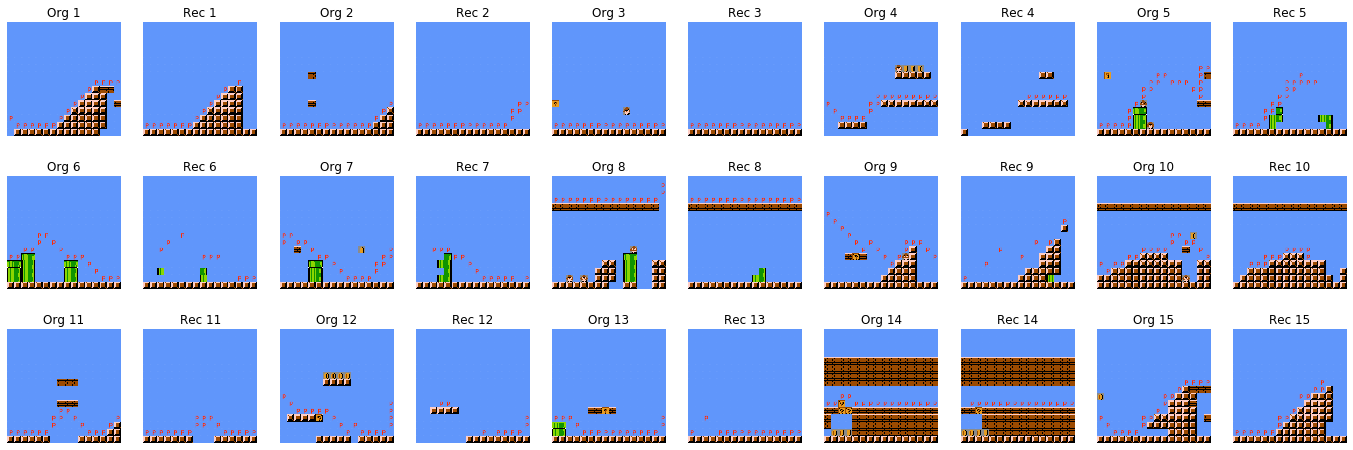

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

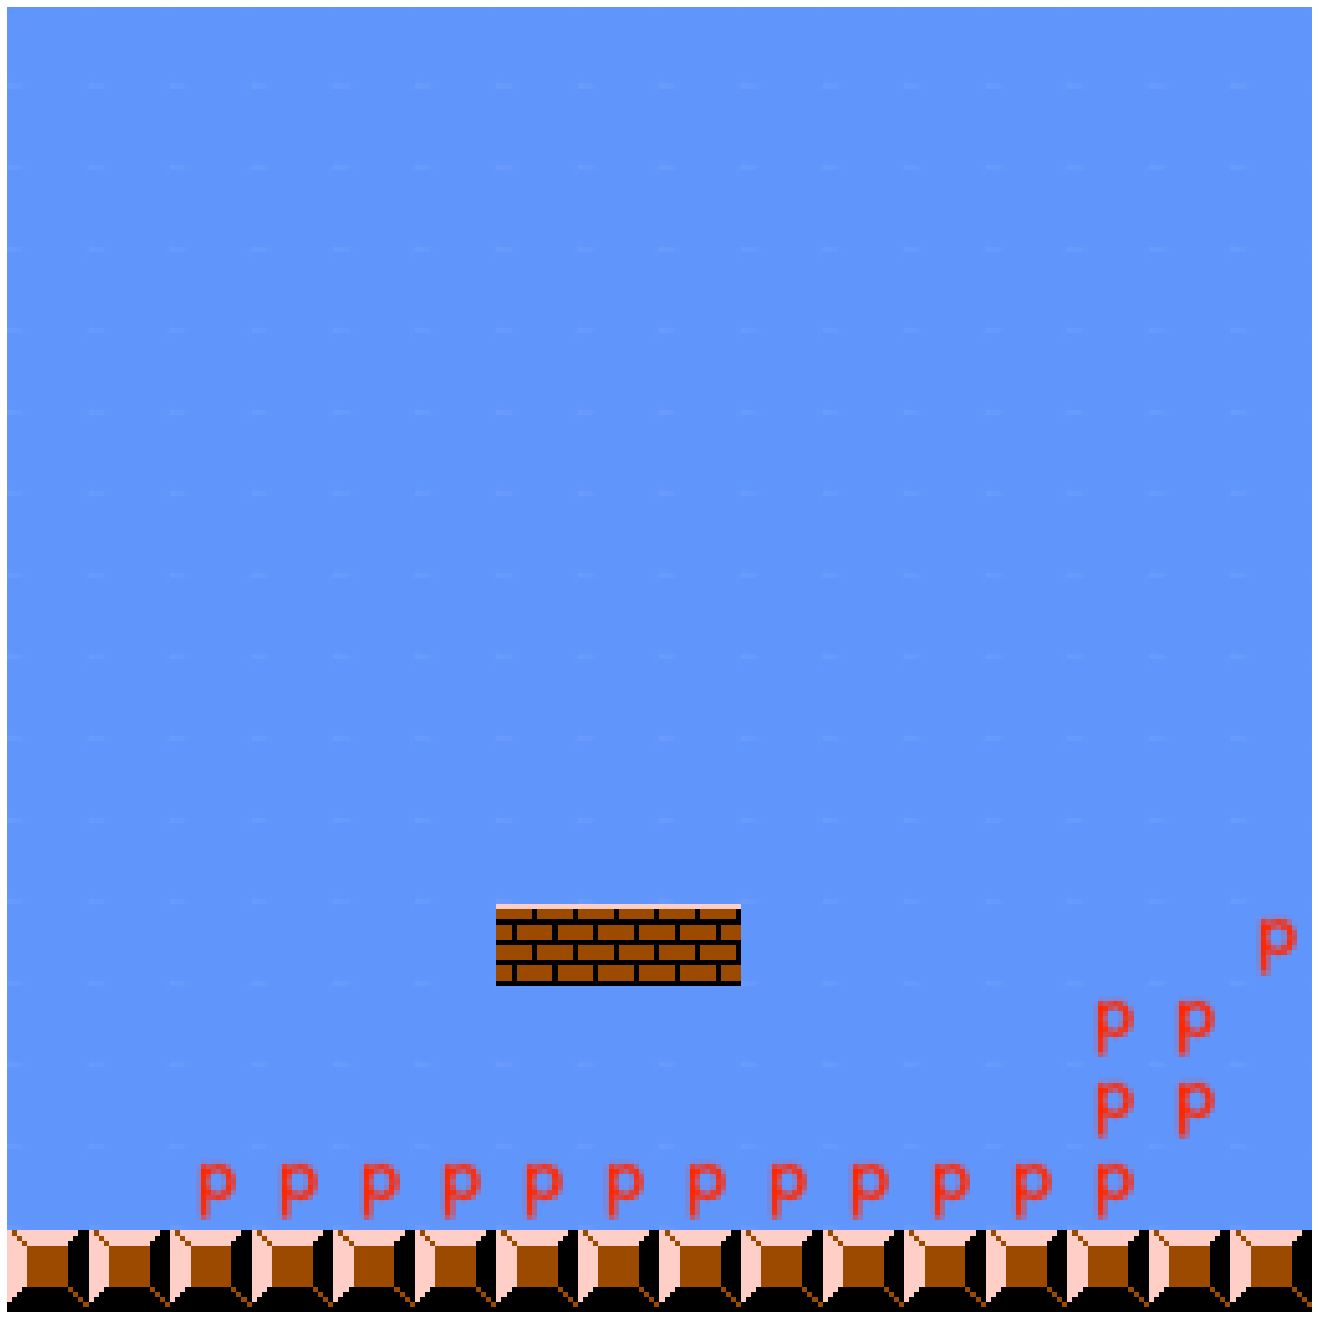

In [28]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,5])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [20]:
generated = vae.random_generation(10000)
generated.shape

(10000, 3072)

In [21]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [22]:
generated_int.shape

(10000, 16, 16)

In [ ]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_vae_kld_loss_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [33]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, True)

In [34]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [35]:
test_labels_subset = test_labels[:first_n]

In [36]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

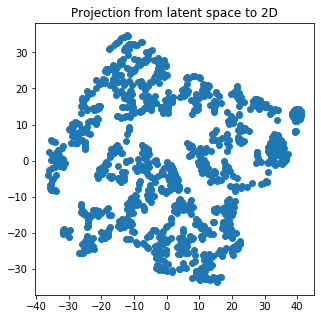

In [37]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_])

plt.title('Projection from latent space to 2D')
plt.show()